# Case Description

You were hired as a data scientist in an important mutual fund firm (investment company) in the department of financial analysis. The firm has been doing financial analysis and financial forecast for several years. You were hired to come up with alternative approaches to do descriptive analytics in order to find better future alternatives for forecasting methods.

You have to analyze historical quarterly financial statements of all US public firms listed in the New York Exchange and NASDAQ. You will receive two datasetsin .csv format. The first dataset (dataus2023q2) contains the historical financial data of the firms, while the second dataset (firmsus2023) is a catalog of all firms along with the corresponding industry type and status (active or cancelled).

The dataus2023q2 dataset has a panel-data (also called long format) structure. Each row has financial information for one US firm and 1 period (a quarter). All $ amounts are in thousands (’1000s).

The main objectives of your analysis are a) To learn about the firm composition of whole US financial market (using all firms), and b) Select firms from 1 industry and then learn which financial factors/variables are related to stock return.

In the following sections you will find specific directions to calculate new variables/ratios, provide descriptive statistics and do a statistical analysis to aim the objective.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sn
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd
#put your own path in google drive
%cd "/content/gdrive/MyDrive/AI/Statistics_Project_Module2"
!ls

Mounted at /content/gdrive
/content
/content/gdrive/MyDrive/AI/Statistics_Project_Module2
dataus2023.csv	firmsus2023.csv


In [3]:
data = pd.read_csv("dataus2023.csv")
print(data.shape)

firms = pd.read_csv("firmsus2023.csv")
print(firms.shape)

(533088, 22)
(5615, 7)


In [4]:
data['qdate']=pd.PeriodIndex(data.q, freq="Q")

In [5]:
data.set_index(['firm', 'qdate'], inplace = True)

In [6]:
firms.columns
firms1 = firms[["empresa", "Nombre", "status", "naics1"]]
firms1.columns = ['firm', 'Empresa', 'status', 'industria']

# 1.1 Calculation of financial variables and ratios

* Calculate log quarterly returns (rq) and log annual returns (ry).

* Calculate 1-quarter future log quarterly returns (f1rq)

In [7]:
data['ry'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(4))
data['rq'] = np.log(data['adjprice']) - np.log(data.groupby(['firm'])['adjprice'].shift(1))

data['f1rq'] = data.groupby(['firm'])['rq'].shift(-1)
data['f4rq'] = data.groupby(['firm'])['rq'].shift(-4)

data['f1ry'] = data.groupby(['firm'])['ry'].shift(-1)
data['f4ry'] = data.groupby(['firm'])['ry'].shift(-4)

In [8]:
data = pd.merge(data, firms1, on="firm", how='left')
data[['firm', 'q', 'rq', 'ry', 'f1rq', 'f4rq']].head(10)

,firm,q,rq,ry,f1rq,f4rq
0,A,2000q1,NaN,NaN,-0.343710,-0.577538
1,A,2000q2,-0.343710,NaN,-0.410137,0.056001
2,A,2000q3,-0.410137,NaN,0.112233,-0.508265
3,A,2000q4,0.112233,NaN,-0.577538,0.377280
4,A,2001q1,-0.577538,-1.219152,0.056001,0.203950
5,A,2001q2,0.056001,-0.819441,-0.508265,-0.390841
6,A,2001q3,-0.508265,-0.917569,0.377280,-0.593809
7,A,2001q4,0.377280,-0.652522,0.203950,0.318593
8,A,2002q1,0.203950,0.128965,-0.390841,-0.311725
9,A,2002q2,-0.390841,-0.317877,-0.593809,0.396554


In [9]:
data.head()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,yearf,ry,rq,f1rq,f4rq,f1ry,f4ry,Empresa,status,industria
0,A,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.343710,-0.577538,NaN,-1.219152,"Agilent Technologies, Inc",activo,Industrias manufactureras
1,A,2000q2,6.0,4731000.0,2421000.0,1925000.0,73000.0,0.0,0.0,161000.0,...,2000.0,NaN,-0.343710,-0.410137,0.056001,NaN,-0.819441,"Agilent Technologies, Inc",activo,Industrias manufactureras
2,A,2000q3,9.0,7401000.0,3790000.0,3016000.0,101000.0,0.0,0.0,244000.0,...,2000.0,NaN,-0.410137,0.112233,-0.508265,NaN,-0.917569,"Agilent Technologies, Inc",activo,Industrias manufactureras
3,A,2000q4,12.0,10773000.0,5522000.0,4198000.0,111000.0,0.0,0.0,407000.0,...,2000.0,NaN,0.112233,-0.577538,0.377280,-1.219152,-0.652522,"Agilent Technologies, Inc",activo,Industrias manufactureras
4,A,2001q1,3.0,2841000.0,1449000.0,1113000.0,19000.0,-25000.0,0.0,119000.0,...,2001.0,-1.219152,-0.577538,0.056001,0.203950,-0.819441,0.128965,"Agilent Technologies, Inc",activo,Industrias manufactureras


* Calculate operating profit (also called earnings before interest and taxes) : ebit = revenue - cogs - sgae

* Calculate operating profit margin: opm = ebit / revenue

* Calculate net income as: netincome = ebit + otherincome + extraordinaryitems - financial expenses - incometax

* Calculate profit margin (ratio) as: pm = ni / revenue

* Calculate asset turn over ratio: ato = revenue / totalassets

* Calculate acid ratio: acidratio = currentassets / currentliabilities

* Calculate financial leverage ratio as: finlev=longdebt / totalassets

* Calculate market value as: mvalue = originalprice * sharesoutstanding

* Calculate book value as: bookvalue = totalassets - totalliabilities

In [10]:
data['ebit']= data['revenue'] - data['cogs'] - data['sgae']
data['opm']= np.where(data['revenue']==0,np.NaN,data['ebit']/data['revenue'])
data['netincome']= data['ebit'] - data['extraordinaryitems'] - data['incometax'] -data ['finexp']
data['pm']= np.where(data['revenue']==0,np.NaN,data['netincome']/data['revenue'])
data['ato']= np.where(data['totalassets']==0,np.NaN,data['revenue']/data['totalassets'])
data['acidratio']= np.where(data['currentliabilities']==0,np.NaN,data['currentassets']/data['currentliabilities'])
data['finlev']= np.where(data['totalassets']==0,np.NaN,data['longdebt']/data['totalassets'])
data['mvalue']= data['originalprice'] * data['sharesoutstanding']
data['bookvalue']= data['totalassets'] - data['totalliabilities']

# ---------------------------------------------
# Size of the company, categorical values


data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533088 entries, 0 to 533087
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   firm                533088 non-null  object 
 1   q                   533088 non-null  object 
 2   fiscalmonth         240848 non-null  float64
 3   revenue             240837 non-null  float64
 4   cogs                240837 non-null  float64
 5   sgae                209734 non-null  float64
 6   otherincome         240837 non-null  float64
 7   extraordinaryitems  209734 non-null  float64
 8   finexp              240837 non-null  float64
 9   incometax           240837 non-null  float64
 10  totalassets         240842 non-null  float64
 11  currentassets       234044 non-null  float64
 12  inventory           198227 non-null  float64
 13  totalliabilities    240841 non-null  float64
 14  currentliabilities  198231 non-null  float64
 15  longdebt            222677 non-nul

# 1.2 Firm Composition of the US financial market

In [11]:
data.status.unique()

array(['activo', 'cancelado'], dtype=object)

* Show how many active firms by industry there are in the sample

In [12]:
active_2023q2=data.loc[(data['status']=="activo")&(data['q']=="2023q2")]
active_2023q2[["industria", 'firm']].groupby('industria').count()

,firm
industria,
-,2
"Agricultura, ganadería, aprovechamiento forestal, pesca y caza",17
Comercio al por mayor,79
Comercio al por menor,145
Construcción,46
"Empresas de electricidad, gas y agua",77
Industrias manufactureras,1540
Información en medios masivos,256
"Minería, explotación de canteras y extracción de petróleo y gas",113


In [13]:
industrysummary = active_2023q2.groupby('industria').agg(
    {
    'firm':['count'],
    'mvalue': ['min', 'max', 'mean', 'median', 'std'],
    'bookvalue': ['min', 'max', 'mean', 'median', 'std']
    }
)
industrysummary

firm        mvalue  \
                                                   count           min   
industria                                                                
-                                                      2  5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...    17  3.687575e+03   
Comercio al por mayor                                 79  5.458413e+03   
Comercio al por menor                                145  3.795684e+03   
Construcción                                          46  2.212283e+03   
Empresas de electricidad, gas y agua                  77  3.372824e+04   
Industrias manufactureras                           1540  7.961721e+02   
Información en medios masivos                        256  3.256724e+03   
Minería, explotación de canteras y extracción d...   113  3.417000e+01   
Otros servicios excepto actividades gubernament...    17  1.674210e+04   
Servicios de alojamiento temporal y de preparac...    71  9.806644e+03   
Servicios de apoyo a los negocios y manejo de r...   128  2.802163e+03   
Servicios de esparcimiento culturales y deporti...    24  3.092327e+03   
Servicios de salud y de asistencia social             63  7.174165e+02   
Servicios educativos                                  13  8.398636e+04   
Servicios financieros y de seguros                   686  5.559044e+03   
Servicios inmobiliarios y de alquiler de bienes...    68  3.440615e+03   
Servicios profesionales, científicos y técnicos      137  3.638322e+03   
Transportes, correos y almacenamiento                 70  2.981646e+04   

                                                                  \
                                                             max   
industria                                                          
-                                                   5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...  4.505009e+07   
Comercio al por mayor                               5.764514e+07   
Comercio al por menor                               1.337540e+09   
Construcción                                        4.150495e+07   
Empresas de electricidad, gas y agua                1.501596e+08   
Industrias manufactureras                           3.050896e+09   
Información en medios masivos                       2.532081e+09   
Minería, explotación de canteras y extracción d...  6.980866e+07   
Otros servicios excepto actividades gubernament...  9.764061e+06   
Servicios de alojamiento temporal y de preparac...  2.174703e+08   
Servicios de apoyo a los negocios y manejo de r...  4.448753e+08   
Servicios de esparcimiento culturales y deporti...  1.631418e+08   
Servicios de salud y de asistencia social           8.351460e+07   
Servicios educativos                                3.171234e+06   
Servicios financieros y de seguros                  7.507354e+08   
Servicios inmobiliarios y de alquiler de bienes...  1.952017e+08   
Servicios profesionales, científicos y técnicos     1.519831e+09   
Transportes, correos y almacenamiento               1.539554e+08   

                                                                  \
                                                            mean   
industria                                                          
-                                                   5.231092e+06   
Agricultura, ganadería, aprovechamiento foresta...  7.682534e+06   
Comercio al por mayor                               6.028485e+06   
Comercio al por menor                               2.472093e+07   
Construcción                                        5.996741e+06   
Empresas de electricidad, gas y agua                1.544664e+07   
Industrias manufactureras                           1.290139e+07   
Información en medios masivos                       2.339430e+07   
Minería, explotación de canteras y extracción d...  6.854571e+06   
Otros servicios excepto actividades gubernament...  1.956204e+06   
Servicios de alojamiento temporal y de pre

* For each industry (and for all industries), what can you say about the typical firm size in terms of market value and book value? How much these variables change within each industry? How firm size (in market value) is distributed? You have to do the right descriptive statistics

IN ORDER TO DESCRIBE THE TYPICAL FIRM SIZE IN ACCORDANCE TO THE MARKET VALUE AND THE BOOK VALUE, I WILL BE ANALYZING THE MEDIAN VALUES ACCORDINGLY, DUE THE FACT THAT THE MEAN, IN THIS CASE, DOES NOT REPRESENT THE TRUE 50TH PERCENTILE OF THE INDUSTRIES.

NOW WE'LL BE TAKING A LOOK WITHIN EACH INDUSTRY AND ANALYZING ITS PROPER MEDIAN FOR THE MARKET VALUE:

*Agriculture, ganadería, aprovechamiento forestal, pesca y caza:* The typical firm in this industry has a median market value of approximately $857,921.50.

 Market values vary with a standard deviation of approximately $1,516,353. This suggests significant variability in market values within this industry.

_Comercio al por mayor_: The typical firm in wholesale trade has a median market value of approximately $883,300.

 The standard deviation is approximately $3,028,155
indicating substantial variability in market values.

_Comercio al por menor_: Firms in retail trade have a median market value of approximately $5,443,400.

 Market values vary with a standard deviation of approximately $16,956,070, indicating significant variation.

_Industrias manufactureras_: Firms in manufacturing have a median market value of approximately $2,776,380.

The standard deviation is approximately $10,530,440, indicating notable variability in market values.

_Información en medios masivos_: Media firms have a median market value of approximately $5,079,650.

The standard deviation is approximately $18,389,290, suggesting substantial variation.

_Minería, explotación de canteras y extracción de petróleo y gas_: This industry has a median market value of approximately $9,985,605.

The standard deviation is approximately $5,908,949, indicating considerable variability in market values.

_Other Services_: The typical firm in this category has a median market value of approximately $1,463,740.

 The standard deviation is approximately $757,627.5, suggesting some variability in market values.

_Servicios de alojamiento temporal y de preparación de alimentos y bebidas_: Firms in this category have a median market value of approximately $2,073,125.

The standard deviation is approximately $2,312,744, indicating variability.

_Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación_: Firms in this category have a median market value of approximately $626,235.5.

 The standard deviation is approximately $6,367,508, indicating considerable variability.

_Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos_: This industry has a median market value of approximately $481,245.

 The standard deviation is approximately $21,692,360, indicating significant variation.

_Servicios de salud y de asistencia social_: The typical firm in this category has a median market value of approximately $489,998.

The standard deviation is approximately $1,678,627, suggesting some variability in market values.

_Servicios educativos_: Firms in education have a median market value of approximately $792,432.

 The standard deviation is approximately $996,208, indicating variability in market values.

_Servicios financieros y de seguros_: This industry has a median market value of approximately $1,191,918.

 The standard deviation is approximately $30,592,410, indicating notable variation.

_Servicios inmobiliarios y de alquiler de bienes muebles e intangibles_: The typical firm in this category has a median market value of approximately $613,070.

 The standard deviation is approximately $3,560,030, suggesting some variability in market values.

_Servicios profesionales, científicos y técnicos_: Firms in this category have a median market value of approximately $2,585,840.

The standard deviation is approximately $25,988,950, indicating substantial variation.

*Transportes, correos y almacenamiento*: This industry has a median market value of approximately $1,443,204.

 The standard deviation is approximately $6,284,040, indicating significant variability.




Industries like "Comercio al por menor," "Industrias manufactureras," "Información en medios masivos," and "Servicios financieros y de seguros" generally usually have higher median market values than other industries.

Most industries demonstrate significant variability in their market values, which is shown by noteworthy standard deviations.

However, "Comercio al por menor" and "Información en medios masivos"  have particularly high variability in market values.

The "Agricultura, ganadería, aprovechamiento forestal, pesca y caza" sector generally has lower median market values and less variation when compared to other sectors.

To put it briefly, the average size of a firm, as evaluated by its market value, differs considerably depending on the sector, with certain sectors having bigger typical firm sizes and greater variation than others.

Descriptive Statistics for book value



Summarizing the key points:

Variability Across Industries: Book values vary significantly across different industries, with some industries having much higher book values than others.

High Variability: Within most industries, there is considerable variability in book values, as indicated by notable standard deviations.

Retail and Media Industries: Retail trade and media industries tend to have relatively high median book values compared to other sectors.

Manufacturing: The manufacturing sector also exhibits notable variability in book values, with a wide range of firm sizes.

Services Industries: Various services industries, such as healthcare, education, and business support services, show some variability in book values, but they generally have lower median book values compared to other sectors.

Financial Services: The financial services industry stands out for having a relatively high median book value and significant variability in book values.

### Which are the biggest 10 US firms in terms of market value and how far they are from the typical size of a US firm?

In [14]:
active_2023q2[['firm','mvalue', 'Empresa', 'industria']].sort_values(by='mvalue', ascending=False).head(10)

,firm,mvalue,Empresa,industria
1138,AAPL,3.050896e+09,Apple Inc,Industrias manufactureras
316182,MSFT,2.532081e+09,Microsoft Corp,Información en medios masivos
207232,GOOGL,1.519831e+09,Alphabet Inc,"Servicios profesionales, científicos y técnicos"
28396,AMZN,1.337540e+09,"Amazon.Com, Inc",Comercio al por menor
338687,NVDA,1.044859e+09,Nvidia Corp,Industrias manufactureras
478367,TSLA,8.296811e+08,"Tesla, Inc",Industrias manufactureras
72866,BRK_A,7.507354e+08,Berkshire Hathaway Inc,Servicios financieros y de seguros
301173,META,7.354528e+08,"Meta Platforms, Inc","Servicios profesionales, científicos y técnicos"
489577,UNH,4.474912e+08,Unitedhealth Group Inc,Servicios financieros y de seguros
280653,LLY,4.451900e+08,Eli Lilly And Company,Industrias manufactureras


In [15]:
print(active_2023q2['mvalue'].median())

1170074.0124050002


When looking at the top 10 firms, whether by market value or book value, it makes more sense to use the median as the benchmark for the typical firm. This is because, in most cases, the median gives a more accurate picture of what an average firm in this group is like. If we were to use the average (mean), it could be skewed by firms with extremely high earnings. Essentially, the average is easily swayed by outliers, like firms that earn ten times more than the others.

In [16]:
median_mvalue = active_2023q2['mvalue'].median()
print(median_mvalue)

1170074.0124050002


All of the listed firms are significantly larger than the typical size of a US firm in terms of market value, with differences ranging from hundreds of millions to billions of dollars.

### Which are the biggest 10 US firms in terms of book value and how far they are from the typical size of a US firm?

In [17]:
active_2023q2[['firm','bookvalue', 'Empresa', 'industria']].sort_values(by='bookvalue', ascending=False).head(10)

,firm,bookvalue,Empresa,industria
72866,BRK_A,539883000.0,Berkshire Hathaway Inc,Servicios financieros y de seguros
259753,JPM,312516000.0,Jpmorgan Chase & Co,Servicios financieros y de seguros
53286,BAC,283319000.0,Bank Of America Corp,Servicios financieros y de seguros
207232,GOOGL,267141000.0,Alphabet Inc,"Servicios profesionales, científicos y técnicos"
79421,C,209422000.0,Citigroup Inc,Servicios financieros y de seguros
525961,XOM,206997000.0,Exxon Mobil Corp,Industrias manufactureras
316182,MSFT,206223000.0,Microsoft Corp,Información en medios masivos
513136,WFC,181952000.0,Wells Fargo & Company,Servicios financieros y de seguros
28396,AMZN,168602000.0,"Amazon.Com, Inc",Comercio al por menor
127623,CVX,159298000.0,Chevron Corp,Industrias manufactureras


The table shows the top 10 US companies in terms of book value, all of them active during the second quarter of the year 2023. Another thing to denote is  that 50% of these companies operate in the financial and insurance services sector.

In [18]:
median_bookvalue = active_2023q2['bookvalue'].median()
print(median_bookvalue)

500654.5


These are the 10 biggest US firms in terms of book value, and each of them is significantly larger than the typical size of a US firm in terms of book value, with differences ranging from hundreds of millions to billions of dollars.

# Evolution of the US financial market

Considering the whole history of financial data for all firms, and only annual fiscal information (selecting fiscalmonth=12) :

* How the total market value of the US market has changed over the years? Do a table and/or graph and explain

* How total revenue and total net income of all US firms has changed over the years? Do a table and/or graph and explain

In [19]:
datay = data.loc[(data['fiscalmonth'] == 12) & (data['year'] < 2023)]
fmarket = datay[['year', 'mvalue', 'revenue', 'netincome']].groupby('year').sum()
fmarket

,mvalue,revenue,netincome
year,,,
2000,1.281498e+10,6.650301e+09,2.697602e+08
2001,1.149439e+10,7.757320e+09,1.241661e+08
2002,9.494723e+09,7.575464e+09,3.352811e+08
2003,1.167595e+10,8.213607e+09,3.194297e+08
2004,1.323088e+10,9.111917e+09,4.268007e+08
2005,1.378911e+10,9.975746e+09,4.789271e+08
2006,1.546125e+10,1.094177e+10,5.226893e+08
2007,1.614913e+10,1.160374e+10,5.098830e+08
2008,1.039502e+10,1.176985e+10,3.273042e+08


In [20]:
fmarket = fmarket.loc[fmarket.index]

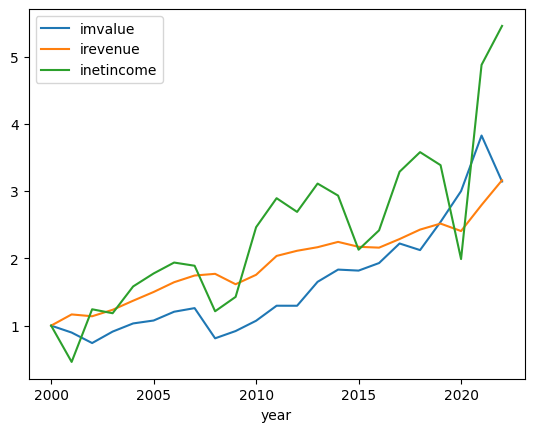

In [21]:
fmarket['imvalue'] = fmarket['mvalue'] / fmarket['mvalue'][2000]
fmarket['irevenue'] = fmarket['revenue'] / fmarket['revenue'][2000]
fmarket['inetincome'] = fmarket['netincome'] / fmarket['netincome'][2000]

fmarket.plot(y=['imvalue', 'irevenue', 'inetincome'])
plt.show()

From this graph we can extract the following:
The normalized total market value ('imvalue') of the US market appeared to lag behind the normalized total revenue ('irevenue') until roughly 2019. This suggests that, for a period, the overall market value of US firms wasn't growing as rapidly as their total revenue.

Around 2021 or 2022, 'imvalue' reached a peak, signifying a shift where market value started catching up and surpassing the total revenue. This could imply that investors began to place more value on the assets and potential growth of US firms.

By approximately 2023, 'imvalue' stabilized and remained slightly below 'irevenue.' This indicates that a relatively balanced relationship between the total market value and total revenue was established.


As for the netincome and the revenue,

'inetincome' consistently maintained a position above 'imvalue' and 'irevenue,' indicating that the aggregate net income of US firms exceeded both their total market value and total revenue.

A notable decline in 'inetincome' occurred in 2020, potentially influenced by various economic factors, notably the impact of the COVID-19 pandemic.

However, in subsequent years, 'inetincome' displayed a robust recovery and even surpassed both 'irevenue' and 'imvalue.' This suggests a significant resurgence in total net income, potentially reflecting improved profitability and economic conditions during those periods. Maybe even due to factors like economic incentives and a recovery from the COVID-19 pandemic.

As for the revenue:
'irevenue' has exhibited a sustained upward trajectory, implying a continuous increase in the aggregate revenue of US firms over the years.


In all 3 variables, we can see an overall positive (upwards) trend is highly related to the expansion and growth of the US market in recent years.

# Learing about one industry

In [22]:
#Select my Industry
#In this case we'll be analyzing the Service industries
dataser= data.loc[(data['industria']== 'Servicios de alojamiento temporal y de preparación de alimentos y bebidas') |
                  (data['industria']=='Servicios de apoyo a los negocios y manejo de residuos y desechos, y servicios de remediación') |
                  (data['industria']=="Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos") |
                  (data['industria']=="Servicios de salud y de asistencia social") |
                  (data['industria']=="Servicios educativos") |
                  (data['industria']=="Servicios profesionales, científicos y técnicos") |
                  (data['industria']=="Servicios inmobiliarios y de alquiler de bienes muebles e intangibles") |
                  (data['industria']=="Transportes, correos y almacenamiento")]
dataser[['industria']].head()

,industria
190,"Servicios profesionales, científicos y técnicos"
191,"Servicios profesionales, científicos y técnicos"
192,"Servicios profesionales, científicos y técnicos"
193,"Servicios profesionales, científicos y técnicos"
194,"Servicios profesionales, científicos y técnicos"


In [ ]:
dataser2022 = dataser.loc[(dataser['year']==2022) & (dataser['fiscalmonth']==12) & (dataser['status']=='activo')]
dataser2022 = dataser2022[['firm','q','totalassets','revenue','netincome','mvalue','bookvalue','opm','pm','ato','finlev','acidratio','rq','ry','f1rq']]
dataser2022.describe()

,totalassets,revenue,netincome,mvalue,bookvalue,opm,pm,ato,finlev,acidratio,rq,ry,f1rq
count,5.550000e+02,5.550000e+02,5.500000e+02,5.500000e+02,5.550000e+02,545.000000,545.000000,555.000000,533.000000,527.000000,548.000000,540.000000,550.000000
mean,7.697660e+06,4.833614e+06,3.555505e+05,1.112014e+07,2.538049e+06,-2.118152,-2.765817,0.884533,0.332503,3.013270,-0.016142,-0.452699,0.033040
std,2.296538e+07,1.604349e+07,3.291170e+06,5.714457e+07,1.337700e+07,23.474751,34.774712,1.489614,0.291073,10.310960,0.289725,0.621442,0.266429
min,2.704282e+03,0.000000e+00,-1.675900e+07,3.455370e+03,-8.876000e+06,-459.916667,-755.416667,0.000000,0.000000,0.061452,-1.845058,-3.314782,-1.374598
25%,4.785685e+05,2.762240e+05,-2.898000e+04,3.219927e+05,7.116205e+04,-0.061337,-0.089161,0.364548,0.090553,1.000816,-0.121734,-0.685847,-0.082171
50%,1.733400e+06,9.679960e+05,1.827400e+04,1.444956e+06,4.802230e+05,0.060719,0.030860,0.627985,0.289875,1.465848,0.041209,-0.303200,0.042836
75%,5.945813e+06,3.663277e+06,2.125865e+05,5.335943e+06,1.665617e+06,0.152147,0.093356,1.071085,0.487532,2.378899,0.154247,-0.045514,0.166593
max,3.652640e+08,2.828360e+08,6.348600e+07,1.141961e+09,2.561440e+08,0.810083,0.686365,29.462489,1.959117,208.291382,0.883855,1.235678,1.205105


In [ ]:
#Dataset con toda la historia, pero que sea información anual

#datasery = dataser[dataser['fiscalmonth']==12]
#datasery[['fiscalmonth','revenue']].head()

datasery = dataser.loc[(dataser['fiscalmonth']==12) & (dataser['status']== 'activo')]
datasery[['fiscalmonth','revenue']].head()

,fiscalmonth,revenue
478,12.0,19703000.0
482,12.0,18963000.0
486,12.0,17299000.0
490,12.0,17440000.0
494,12.0,18645000.0


In [ ]:
# Calculo logaritmo de las variables financieras (no de los ratios)

datasery['logta'] = np.where(datasery['totalassets']==0,np.NaN,np.log(datasery['totalassets']))
datasery['logrev'] = np.where(datasery['revenue']==0,np.NaN,np.log(datasery['revenue']))
datasery['logni'] = np.where(datasery['netincome']==0,np.NaN,np.log(datasery['netincome']))

<ipython-input-27-ab480b9dbfd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasery['logta'] = np.where(datasery['totalassets']==0,np.NaN,np.log(datasery['totalassets']))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-27-ab480b9dbfd0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasery['logrev'] = np.where(datasery['revenue']==0,np.NaN,np.log(datasery['reve

# Descriptive statistics for your industry

Using the subsample of your industry and using annual fiscal information (selecting rows with fiscalmonth=12), and the most recent complete year (2022), do the following:

* Show descriptive statistics for future quarterly log return, annual return, total assets, revenue, netincome and all financial ratios calculated above. Provide a clear interpretation of the descriptive statistics of revenue and 1 financial ratio

In [ ]:
#selecciono las columnas de las variables a analizar
#'firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue'
dataset2022 = dataser.loc[(dataser['year']==2022)&(dataser['fiscalmonth']==12) & (dataser['status']=="activo")]
dataser2022

,firm,q,totalassets,revenue,netincome,mvalue,bookvalue,opm,pm,ato,finlev,acidratio,rq,ry,f1rq
566,AAL,2022q4,64716000.0,48971000.0,-198000.0,8.266739e+06,-5799000.0,0.032815,-0.004043,0.756706,0.500479,0.710318,0.054941,-0.344972,0.148068
2558,ABM,2022q4,4868900.0,7806600.0,225800.0,2.913982e+06,1717300.0,0.044680,0.028924,1.603360,0.244573,1.153710,0.154724,0.101936,0.016550
2748,ABNB,2022q4,16038000.0,8399000.0,1868000.0,5.413665e+07,5560000.0,0.214549,0.222407,0.523694,0.142287,1.862748,-0.205825,-0.666419,0.374986
3033,ABSI,2022q4,321008.0,5747.0,-107261.0,1.940293e+05,274414.0,-18.574909,-18.663825,0.017903,0.050002,6.173208,-0.399096,-1.362197,-0.182322
4075,ACCD,2022q1,1285529.0,310021.0,-122991.0,1.175789e+06,855794.0,-0.405537,-0.396718,0.241162,0.243598,3.661083,-0.406224,-0.949228,-0.864144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529474,YUMC,2022q4,11826000.0,9569000.0,544000.0,2.286705e+07,7148000.0,0.065733,0.056850,0.809149,0.164722,1.819021,0.146181,0.102143,0.150453
529759,Z,2022q4,6563000.0,1958000.0,-118000.0,7.657172e+06,4482000.0,-0.047497,-0.060266,0.298339,0.274112,13.344444,0.118521,-0.684260,0.322538
531184,ZIP,2022q4,714563.0,904649.0,56140.0,1.809248e+06,28620.0,0.107476,0.062057,1.266017,0.776107,4.876441,-0.004860,-0.417973,-0.029668
531561,ZM,2022q1,7551318.0,4099864.0,1331878.0,3.506630e+07,5780018.0,0.259421,0.324859,0.542934,0.011259,3.914567,-0.450309,-1.008206,-0.082284


In [ ]:
dataset2022 = dataset2022[['firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue']]
dataset2022.describe()

,f1rq,ry,rq,totalassets,revenue,netincome,opm,pm,ato,finlev,acidratio,mvalue,bookvalue
count,550.000000,540.000000,548.000000,5.550000e+02,5.550000e+02,5.500000e+02,545.000000,545.000000,555.000000,533.000000,527.000000,5.500000e+02,5.550000e+02
mean,0.033040,-0.452699,-0.016142,7.697660e+06,4.833614e+06,3.555505e+05,-2.118152,-2.765817,0.884533,0.332503,3.013270,1.112014e+07,2.538049e+06
std,0.266429,0.621442,0.289725,2.296538e+07,1.604349e+07,3.291170e+06,23.474751,34.774712,1.489614,0.291073,10.310960,5.714457e+07,1.337700e+07
min,-1.374598,-3.314782,-1.845058,2.704282e+03,0.000000e+00,-1.675900e+07,-459.916667,-755.416667,0.000000,0.000000,0.061452,3.455370e+03,-8.876000e+06
25%,-0.082171,-0.685847,-0.121734,4.785685e+05,2.762240e+05,-2.898000e+04,-0.061337,-0.089161,0.364548,0.090553,1.000816,3.219927e+05,7.116205e+04
50%,0.042836,-0.303200,0.041209,1.733400e+06,9.679960e+05,1.827400e+04,0.060719,0.030860,0.627985,0.289875,1.465848,1.444956e+06,4.802230e+05
75%,0.166593,-0.045514,0.154247,5.945813e+06,3.663277e+06,2.125865e+05,0.152147,0.093356,1.071085,0.487532,2.378899,5.335943e+06,1.665617e+06
max,1.205105,1.235678,0.883855,3.652640e+08,2.828360e+08,6.348600e+07,0.810083,0.686365,29.462489,1.959117,208.291382,1.141961e+09,2.561440e+08


**Future Quarterly Log Return (f1rq):**

Mean: The average future quarterly log return is approximately 0.033.

Minimum: The smallest observed future quarterly log return is approximately -1.375.

Maximum: The largest observed future quarterly log return is approximately 1.205.

Std: The standard deviation of future quarterly log returns is roughly 0.266, indicating significant variability in this variable.

**Annual Return (ry):**

Mean: The average annual return is approximately -0.453.

Minimum: The smallest observed annual return is approximately -3.315.

Maximum: The largest observed annual return is approximately 1.236.

Std: The standard deviation of annual returns is about 0.621.

**Revenue:**

Mean: The average revenue is approximately $4.83 million.

Minimum: The smallest observed revenue is $0 (probably indicating firms with no recorded revenue).

Maximum: The largest observed revenue is approximately $282.84 million.

Std: The standard deviation of revenue is roughly $16.04 million, showing significant variability in revenue figures.

**Total Assets:**

Mean: The average total assets are approximately $7.70 million.

Minimum: The smallest observed total assets are approximately $2,704.

Maximum: The largest observed total assets are approximately $365.26 million.

Std: The standard deviation of total assets is about $22.97 million.

**Operating Profit Margin (opm):**

Mean: The average operating profit margin is approximately -2.12.

Minimum: The smallest observed operating profit margin is approximately -459.92.

Maximum: The largest observed operating profit margin is approximately 0.810.

Std: The standard deviation of operating profit margins is notably high at approximately 23.47, indicating variability in margin percentages.

Using annual fiscal data (selecting rows with fiscalmonth=12), and all years:

In [ ]:
datasety= dataser.loc[(dataser['fiscalmonth']==12) & (dataser['status']=="activo")]
datasety = datasety[['firm', 'q', 'f1rq', 'ry', 'rq', 'totalassets', 'revenue', 'netincome', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue']]
datasety.describe()

,f1rq,ry,rq,totalassets,revenue,netincome,opm,pm,ato,finlev,acidratio,mvalue,bookvalue
count,6213.000000,5684.000000,6134.000000,6.516000e+03,6.515000e+03,6.481000e+03,6438.000000,6438.000000,6515.000000,6267.000000,6234.000000,6.158000e+03,6.516000e+03
mean,0.003135,0.026157,0.023147,6.311967e+06,4.023898e+06,2.962504e+05,-1.174258,-1.211593,0.947623,0.272559,2.353425,1.047869e+07,2.213705e+06
std,0.273399,0.506159,0.251749,1.603412e+07,1.018303e+07,1.894726e+06,28.036721,26.494866,1.003997,0.291646,5.311153,5.719124e+07,9.315745e+06
min,-2.280112,-4.915325,-2.202502,7.380000e-01,0.000000e+00,-1.675900e+07,-1404.971429,-1226.314286,0.000000,0.000000,0.002831,1.125142e+03,-2.556000e+07
25%,-0.091097,-0.173667,-0.081685,3.840415e+05,2.701640e+05,-5.321000e+03,0.009073,-0.021266,0.421911,0.043958,0.987058,4.504288e+05,9.703625e+04
50%,0.029913,0.083238,0.043669,1.560290e+06,1.082158e+06,3.947600e+04,0.077157,0.041470,0.717154,0.226712,1.426676,1.702196e+06,4.879025e+05
75%,0.138925,0.298886,0.159373,5.301045e+06,3.616307e+06,2.070000e+05,0.161017,0.097481,1.239240,0.410432,2.224119,5.618335e+06,1.606816e+06
max,2.023202,2.930813,1.625311,3.652640e+08,2.828360e+08,6.401300e+07,7.170382,46.390129,32.355468,7.477906,208.291382,2.256959e+09,2.561440e+08


* Show a correlation matrix with the same variables you used for descriptive statistics above, but in the case of totalassets, revenue and netincome, use the logarithmic transformation of their values. Which variables have strongest and significant linear relationship with stock returns (annual and quarterly)? Explain

In [ ]:
#calculo el logaritmo de las variables financieras (no de los ratios)
datasety['logta'] = np.where(datasety['totalassets']==0, np.NaN,np.log(datasety['totalassets']))
datasety['logrev'] = np.where(datasety['revenue']==0, np.NaN,np.log(datasety['revenue']))
datasety['logni'] = np.where(datasety['netincome']==0, np.NaN,np.log(datasety['netincome']))
datasety[['firm', 'logta', 'logrev', 'logni']].head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,firm,logta,logrev,logni
478,AAL,17.081766,16.796281,13.425427
482,AAL,17.307188,16.758000,NaN
486,AAL,17.225569,16.666159,NaN
490,AAL,17.194121,16.674277,NaN
494,AAL,17.174948,16.741089,NaN


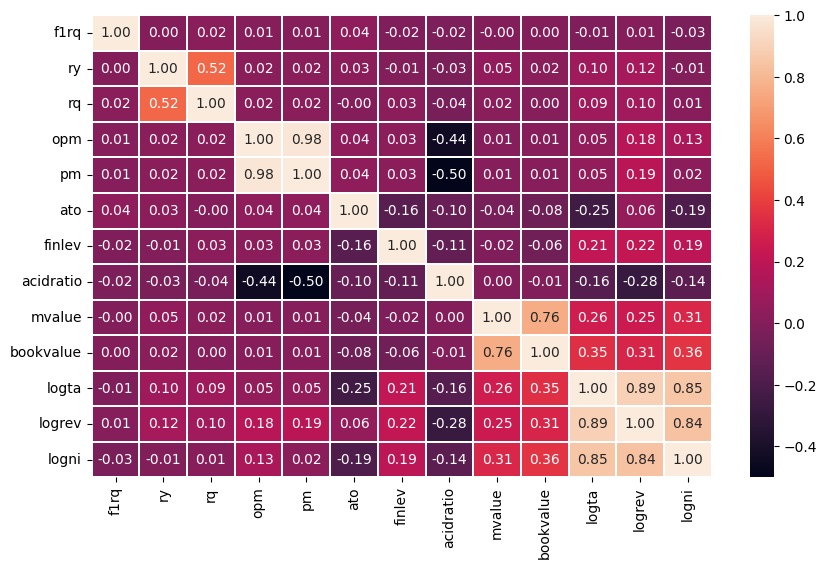

In [ ]:
#Calculate the correlation matrix
corr_matrix = datasety[['f1rq', 'ry', 'rq', 'opm', 'pm', 'ato', 'finlev', 'acidratio','mvalue', 'bookvalue', 'logta', 'logrev', 'logni']].corr()
plt.figure(figsize=(10,6))
sn.heatmap(corr_matrix, annot = True,linewidths=0.3,fmt='0.2f')
plt.show()

The correlation matrix analysis reveals that the variables most closely associated with rq (quarterly stock returns) and ry (annual stock returns) are logta (log of total assets) and logrev (log of revenue). This observation is substantiated by the correlation coefficients:

***For rq:***

1. The correlation with logta is approximately 0.09.
1. The correlation with logrev is approximately 0.10.

***For ry:***

1. The correlation with logta is approximately 0.10.
1. The correlation with logrev is approximately 0.12.

These positive correlation coefficients imply a weak positive linear relationship between both quarterly and annual stock returns and the logarithmic transformations of total assets (logta) and revenue (logrev). However, it's crucial to note that these correlations are relatively weak, with coefficients below the 0.2 threshold. This suggests that while there is a discernible positive linear connection, it lacks substantial strength.

In [ ]:
datasery.reset_index().head()

,index,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,...,netincome,pm,ato,acidratio,finlev,mvalue,bookvalue,logta,logrev,logni
0,478,AAL,2000q4,12.0,19703000.0,0.0,18322000.0,68000.0,34000.0,162000.0,...,677000.0,0.034360,0.751650,0.740916,0.208828,NaN,7176000.0,17.081766,16.796281,13.425427
1,482,AAL,2001q4,12.0,18963000.0,0.0,21433000.0,-2000.0,0.0,284000.0,...,-1760000.0,-0.092812,0.577418,0.870607,0.299443,NaN,5373000.0,17.307188,16.758000,NaN
2,486,AAL,2002q4,12.0,17299000.0,0.0,20629000.0,-2000.0,-988000.0,528000.0,...,-1533000.0,-0.088618,0.571547,0.681906,0.406714,NaN,957000.0,17.225569,16.666159,NaN
3,490,AAL,2003q4,12.0,17440000.0,0.0,18284000.0,113000.0,0.0,577000.0,...,-1341000.0,-0.076892,0.594613,0.713828,0.447528,NaN,46000.0,17.194121,16.674277,NaN
4,494,AAL,2004q4,12.0,18645000.0,0.0,18789000.0,108000.0,0.0,725000.0,...,-869000.0,-0.046608,0.648003,0.708321,0.470024,NaN,-581000.0,17.174948,16.741089,NaN


In [ ]:
#In this section we're going to extract the 3 most correlated variables

correlations = datasety.corr()['f1rq'].abs()  # Calculate absolute correlations

sorted_correlations = correlations.sort_values(ascending=False)

# Extract the top 3 most correlated variables (excluding 'f1rq' itself)
top_3_correlated = sorted_correlations[1:7]

# Print the top 3 most correlated variables and their correlation values
for variable, correlation in top_3_correlated.items():
    print(f"Variable: {variable}, Correlation: {correlation}")



Variable: ato, Correlation: 0.04192080153778566
Variable: logni, Correlation: 0.03297259446909673
Variable: acidratio, Correlation: 0.023208813489088435
Variable: rq, Correlation: 0.019752231608441806
Variable: finlev, Correlation: 0.016852088751338277
Variable: logta, Correlation: 0.014410611703895388


<ipython-input-34-53d92e70bef0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = datasety.corr()['f1rq'].abs()  # Calculate absolute correlations


In [ ]:
import pandas as pd

ratio_variables = ['pm', 'ato', 'acidratio', 'finlev']
#In this section we're going to extract the 3 most correlated ratios

# Calculate correlations between the ratio variables and 'f1rq'
correlations = datasety[ratio_variables].corrwith(datasety['f1rq']).abs()

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Extract the top 3 most correlated ratio variables
top_correlated_ratios = sorted_correlations[0:3].index.tolist()

print("Top 3 most correlated ratio variables with 'f1rq':", top_correlated_ratios)

Top 3 most correlated ratio variables with 'f1rq': ['ato', 'acidratio', 'finlev']


Select 2-3 variables and 2-3 ratios with the strongest correlation with future log quarterly returns and do the following:

The variables with the strongest correlation with future log quarterly returns are the following:
1. *ato*: asset turnover ratio
2. *logni*: natural logarithm of net income
3. _acidratio_: acid ratio

However, since some of the variables are also ratios, then we might have the following list for variables:
1. *logni* natural logarithm of net income
1. *rq* quartely returns
1. *logta* natural logarithm of total assets

The ratios with the strongest correlations with f1rq were the following:
1. *ato* asset turnover ratio
1. _acidratio_ acid ratio
1. _finlev_  financial leverage ratio



* Do histograms for each factor/variables and interpret them

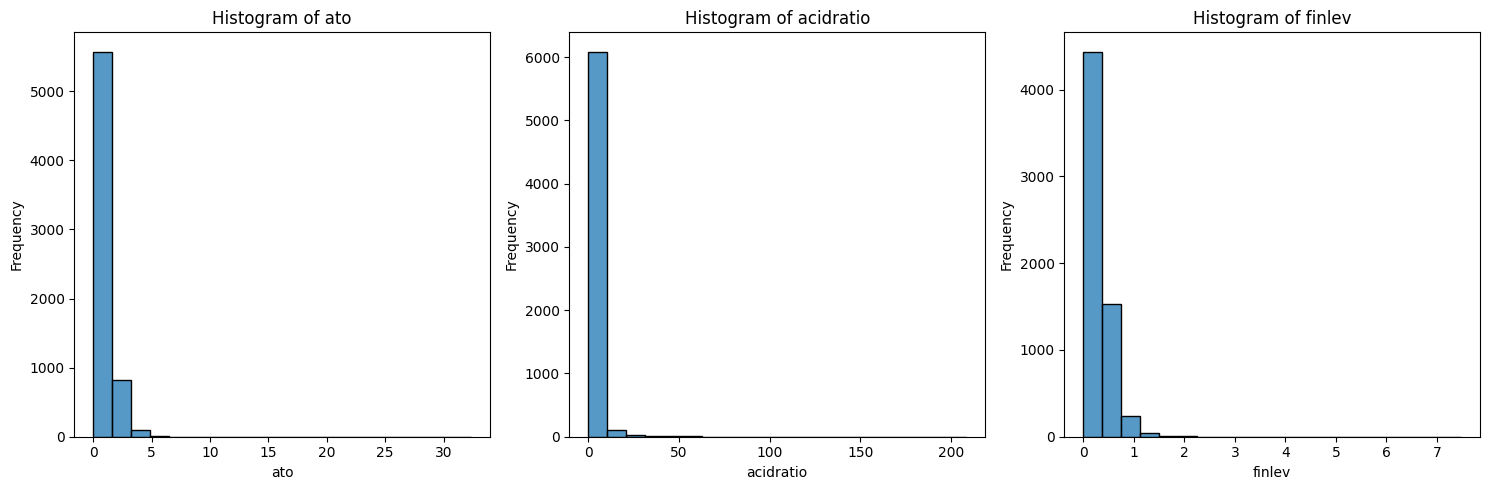

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#Histograms for ratios

# Plot the histogram for 'ato'
sns.histplot(datasety['ato'], bins=20, ax=axes[0])
axes[0].set_title('Histogram of ato')
axes[0].set_xlabel('ato')
axes[0].set_ylabel('Frequency')

# Plot the histogram for 'acidratio'
sns.histplot(datasety['acidratio'], bins=20, ax=axes[1])
axes[1].set_title('Histogram of acidratio')
axes[1].set_xlabel('acidratio')
axes[1].set_ylabel('Frequency')

# Plot the histogram for 'finlev'
sns.histplot(datasety['finlev'], bins=20, ax=axes[2])
axes[2].set_title('Histogram of finlev')
axes[2].set_xlabel('finlev')
axes[2].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the histograms
plt.show()


**ato**

Has a very skewed to the right behaviour in which the hightest frequency turns out to be above 5000. In this case, the graph implies that a majority of the entities or observations in the dataset have a high asset turnover ratio. This implies that many companies or entities are efficient in using their assets to generate.


**acidratio**

Now regarding the acid ratio, it appears to be a strong right-skewed histogram with a peak frequency of around 6000. and the acid ratio range going from 0 to 200.

The right-skewed distribution of the acid ratio suggests that a significant portion of the observed data points falls on the higher end of the scale. The acid ratio, also known as the quick ratio, measures a company's ability to meet short-term financial obligations without relying on the sale of inventory. In this context, a higher acid ratio typically indicates a healthier financial position and a lower risk of liquidity issues.


**finlev**

In this right-skewed distribution of the financial leverage ratio most of the observed data points falls on the higher end of the scale. The financial leverage ratio measures the extent to which a company relies on debt financing. A higher ratio typically indicates higher financial leverage and potentially higher financial risk.

Businesses around the 5000s may have higher financial leverage, possibly due to strategic decisions aimed at growth through debt financing, while those around 1500s may prioritize lower debt levels for risk mitigation.

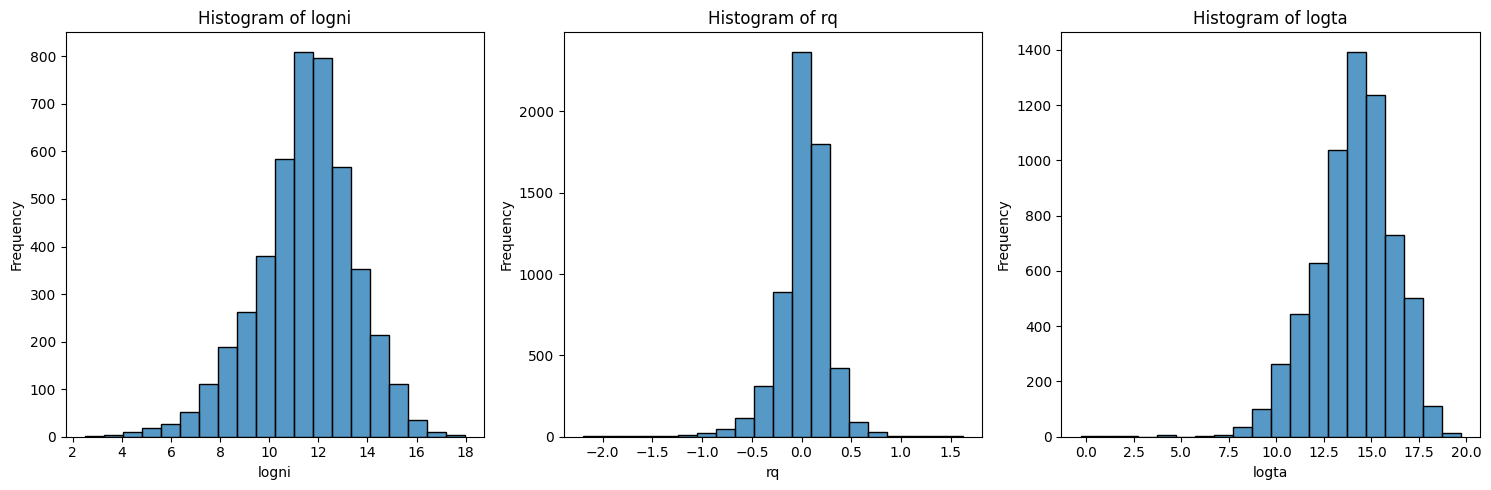

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#Histograms for variables

# Plot the histogram for 'logni'
sns.histplot(datasety['logni'], bins=20, ax=axes[0])
axes[0].set_title('Histogram of logni')
axes[0].set_xlabel('logni')
axes[0].set_ylabel('Frequency')

# Plot the histogram for 'rq'
sns.histplot(datasety['rq'], bins=20, ax=axes[1])
axes[1].set_title('Histogram of rq')
axes[1].set_xlabel('rq')
axes[1].set_ylabel('Frequency')

# Plot the histogram for 'logta'
sns.histplot(datasety['logta'], bins=20, ax=axes[2])
axes[2].set_title('Histogram of logta')
axes[2].set_xlabel('logta')
axes[2].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()

# Show the histograms
plt.show()

**logni**

Now regarding the natural logarithm of netincome:
The x-axis represents the natural logarithm of net income (logni) with a range from 0 to 20, and the y-axis represents frequency, ranging from 0 to 1000. This suggests that the majority of observations fall within the x-axis range of 0 to 20, with a peak frequency around 800.

The relatively close-to-normal distribution of the logged net income suggests that service industries may exhibit a degree of income stability.

The fact that the mean of logged net income is around 12 might indicate that, on average, service-based businesses experience consistent and sustainable growth.

* Do plots to visualize the possible relationship each factor might have with quarterly returns (the dependent variable).

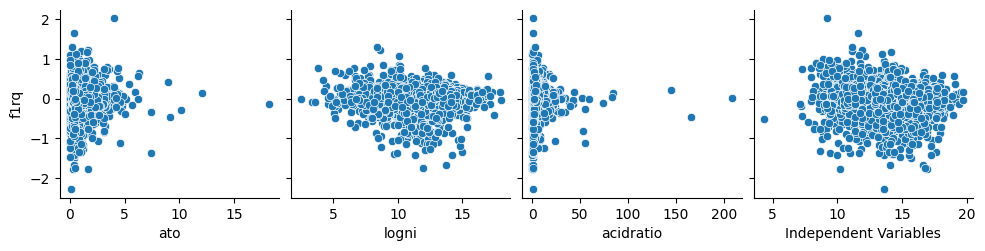

In [ ]:
sn.pairplot(data=datasety, y_vars=['f1rq'], x_vars=['ato', 'logni', 'acidratio', 'logta'])

plt.xlabel('Independent Variables')
plt.ylabel('Quarterly Returns (rq)')

plt.show()

* Design and run a first version of a multiple regression model to examine whether your selected factors can explain/predict quarterly stock returns.



In [ ]:
#datasetnad = datasety.dropna()

X = datasety[['acidratio', 'logni', 'ato', 'finlev']]
X = sm.add_constant(X)

Y = datasety[['f1rq']]
mkmodel = sm.OLS(Y, X,missing= "drop").fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.291
Date:                Wed, 08 Nov 2023   Prob (F-statistic):             0.0106
Time:                        01:33:49   Log-Likelihood:                 341.31
No. Observations:                4266   AIC:                            -672.6
Df Residuals:                    4261   BIC:                            -640.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0332      0.023      1.417      0.1

* You must check for possible multicollinearity problems. Briefly explain what is multicollinearity, run and interpret the corresponding test



In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# X should already be defined as the independent variables with a constant term added
# Replace the column names below with the actual column names in your dataset
X_columns = ['acidratio', 'logni', 'ato', 'finlev']

# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = X_columns
#vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif)

    Variable
0  acidratio
1      logni
2        ato
3     finlev


In simple terms, multicollinearity consists when two or more independent variables in a regression model are highly related or correlated. It's like having redundant information in your data because these variables move together, making it hard to tell which one is actually influencing the dependent variable.

* (OPTIONAL) For each independent variable (variable/ratio) check if winsorization is needed according to very extreme values. You can check this with the histograms of each variable/ratio. If it is necessary do the corresponding adjustments with winsorization to avoid unreliable results in your regression model

* Once you corrected your variables/ratios with winsorization (in case you did it) and addressed possible multicollienarity problems, run a final multiple regression model

# Interpret your model

In [ ]:
#datasetnad = datasety.dropna()

X = datasety[['acidratio', 'logni', 'ato', 'finlev']]
X = sm.add_constant(X)

Y = datasety[['f1rq']]
mkmodel = sm.OLS(Y, X,missing= "drop").fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1rq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.291
Date:                Wed, 08 Nov 2023   Prob (F-statistic):             0.0106
Time:                        01:33:49   Log-Likelihood:                 341.31
No. Observations:                4266   AIC:                            -672.6
Df Residuals:                    4261   BIC:                            -640.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0332      0.023      1.417      0.1

* Interpret with your own words the results of each coefficient (beta and their statistical significance)

* Interpret the R-squared of the model

* Write a conclusion of your results

***Interpretation of Coefficients (Beta) and Their Statistical Significance:***

For this interpretation, I'm going to use as a normal threshold a p-value of 0.05 for comparison. Even though, this threshold could be modified depending on the context of the situation to analyze.

Const (intercept): The constant term doesn't seem to have a strong influence on our dependent variable (f1rq). Its value of 0.0332 doesn't significantly affect f1rq because the p-value (0.156) is higher than the usual accepted threshold of (0.05). This means that when all other factors are zero, this constant doesn't have a strong influence on f1rq.

Acid ratio: A higher acid ratio (by 1 unit) seems to contribute slightly to an increase in f1rq of 0.0020. However, this relationship isn't very reliable as the p-value (0.166) is greater than 0.05. Therefore, we can't say with certainty that the acid ratio has a significant effect on f1rq.

Natural logarithm of net income (logni): A 1 unit increase in the natural logarithm of net income is associated with a 0.0020 decrease in f1rq. However, as with the acid ratio, this relationship isn't strong as the p-value (0.267) is higher than 0.05.

Asset turnover (ATO): An increase of 1 unit in asset turnover corresponds to an increase of 0.0069 in f1rq. While it seems to matter somewhat, we can't be sure because the p-value (0.142) is above 0.05.

Financial leverage (finlev): An increase of 1 unit in financial leverage leads to a decrease of 0.0251 in f1rq. This relationship is somewhat significant with a p-value of 0.077, but it's not very strong. We should be cautious about its significance.

***Interpretation of R-squared (R²):***

Only 0.3% of the variability in f1rq is explained by the independent variables (acid ratio, logni, ato, finlev) in the model, as indicated by the R-squared value of 0.003. The model does not do a good job of explaining or predicting the variation in f1rq. This means that most of the variability remains unaccounted for.

***Conclusion:***

Overall, based on this regression analysis, it appears that the selected independent variables (acidratio, logni, ato, finlev) have a limited or no statistically significant effect on f1rq. The low R-squared value of the model suggests that these variables, as currently included in the model, do not provide a strong explanation for the variation in f1rq.




# 1.2 Multiple Regression - advanced

In [23]:
datam= dataser.loc[(dataser['fiscalmonth']==12)]

In [24]:
# Create sizegroup column based on market value
datam['sizegroup'] = datam.groupby(datam['q'])['mvalue'].transform(lambda x: pd.qcut(x, 3, labels=["small", "medium", "large"]))

# Create cross-tabulation for counts of size categories by quarter
pd.crosstab(index=datam['q'], columns=datam['sizegroup'], values=datam['firm'], aggfunc='count')

# Create dummy variables for sizegroup
datam = pd.get_dummies(datam, columns=['sizegroup'], drop_first=True, dummy_na=True)

# Handle NaN values in dummy variables
datam.loc[datam['sizegroup_nan'] == 1, ["sizegroup_medium", "sizegroup_large"]] = np.nan

<ipython-input-24-f45f993cfb99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datam['sizegroup'] = datam.groupby(datam['q'])['mvalue'].transform(lambda x: pd.qcut(x, 3, labels=["small", "medium", "large"]))


In [25]:
#Calculate operating earnings per share deflated by stock price
datam['oepsp'] = np.where(
    (datam['sharesoutstanding'] == 0) | (datam['originalprice'] == 0),
    np.NaN,  # Set to NaN when sharesoutstanding or originalprice is zero to avoid division by zero
    (datam['ebit'] / datam['sharesoutstanding']) / datam['originalprice']
)

#Calculate earnings per share deflated by stock price
datam['epsp'] = np.where(
    (datam['sharesoutstanding'] == 0) | (datam['originalprice'] == 0),
    np.NaN,  # Set to NaN when sharesoutstanding or originalprice is zero to avoid division by zero
    (datam['netincome'] / datam['sharesoutstanding']) / datam['originalprice']
)

#Calculate book-to-market ratio
datam['bmr']= np.where(datam['mvalue']==0,np.NaN,datam['bookvalue']/datam['mvalue'])


The dependent variable will be "f1ry", which represents the annual returns of a quarter in the future.

# 1.2.2 Winsorization of variables

The variables to be examined for potential winsorization are profit margin, asset turnover, operating earnings per share deflated by stock price, book-to-market ratio, and earnings per share deflated by stock price.

Winsorization is a statistical technique which modifies extreme values in the data to reduce the effect of outliers. Rather than removing outliers completely, winsorization replaces them with less extreme values. This retains the full sample while limiting distortion from anomalous observations.

Winsorization may be appropriate when outliers arise from measurement errors or unusual events unrepresentative of the data's true nature. By dampening outlier impact, it can provide a more robust analysis without discarding potentially useful information.

However, winsorization should be applied judiciously, as it can affect analysis outcomes. First, the specified variables will be evaluated for outliers through histograms, boxplots, means, medians, and value ranges. This will determine whether winsorization is merited for any variables before further analysis. A balanced approach assessing outlier causes will inform appropriate winsorization to obtain valid insights from the data.

In [26]:
print("\t Mean Values")

print("Profit Margin (pm): ", datam['pm'].mean())
print("Asset Turn Over (ato): ",datam['ato'].mean())
print("Operating earnings per share deflated by stock price (oepsp): ",datam['oepsp'].mean())
print("Earnings per share deflated by stock price (epsp): ",datam['epsp'].mean())
print("Book-To-Market (bmr): ",datam['bmr'].mean())

	 Mean Values
Profit Margin (pm):  -1.0898297694743344
Asset Turn Over (ato):  0.9295678994215515
Operating earnings per share deflated by stock price (oepsp):  -0.04632075215565185
Earnings per share deflated by stock price (epsp):  -0.13831806375335642
Book-To-Market (bmr):  0.18931920689677736


In [27]:
print("\t Median Values")
print("Profit Margin (pm): ", datam['pm'].median())
print("Asset Turn Over (ato): ",datam['ato'].median())
print("Operating earnings per share deflated by stock price (oepsp): ",datam['oepsp'].median())
print("Earnings per share deflated by stock price (epsp): ",datam['epsp'].median())
print("Book-To-Market (bmr): ",datam['bmr'].median())

	 Median Values
Profit Margin (pm):  0.04005186122436228
Asset Turn Over (ato):  0.7292887739280822
Operating earnings per share deflated by stock price (oepsp):  0.054394280302460775
Earnings per share deflated by stock price (epsp):  0.030590367597219593
Book-To-Market (bmr):  0.3597357124226359


If the mean and median are similar, it suggests that the data is normally distributed. However, if the mean and median are different, it indicates that the data is skewed.

In this case, we can see that for all five variables, the mean and median are different. This suggests that the data is skewed. The direction of the skewness can be determined by comparing the mean and median. If the mean is greater than the median, the data is positively skewed, and if the mean is less than the median, the data is negatively skewed.

In order to further analyze the outliers of the variables it would be in the best of interest to visualize the data through histograms and boxplots in order to really comprehend how far apart the outliers.

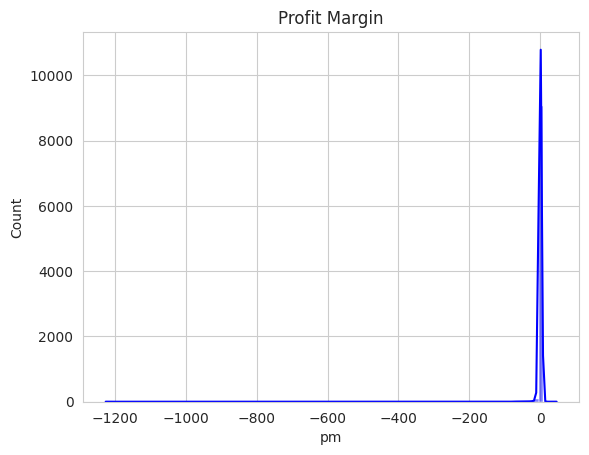

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create the histogram plot
sns.histplot(datam['pm'], bins=100, kde=True, color='blue')

# Set the title
plt.title('Profit Margin')

# Display the plot
plt.show()

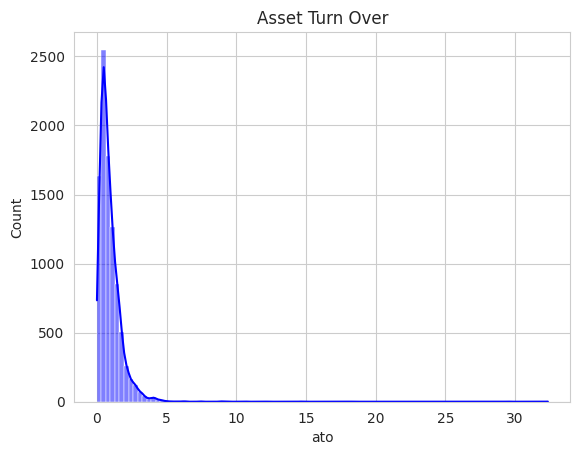

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create the histogram plot
sns.histplot(datam['ato'], bins=100, kde=True, color='blue')

# Set the title
plt.title('Asset Turn Over')

# Display the plot
plt.show()

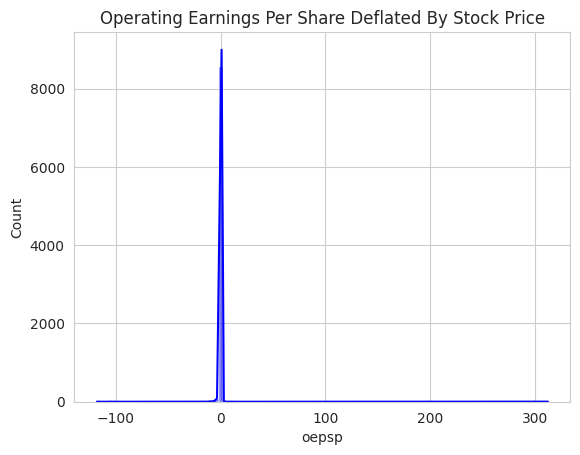

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create the histogram plot
sns.histplot(datam['oepsp'], bins=100, kde=True, color='blue')

# Set the title
plt.title('Operating Earnings Per Share Deflated By Stock Price')

# Display the plot
plt.show()

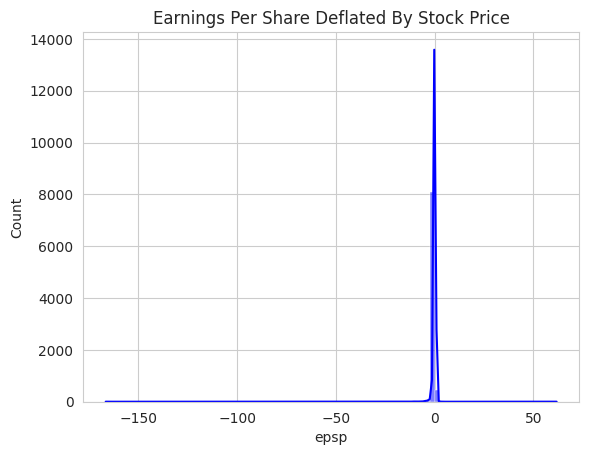

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create the histogram plot
sns.histplot(datam['epsp'], bins=100, kde=True, color='blue')

# Set the title
plt.title('Earnings Per Share Deflated By Stock Price')

# Display the plot
plt.show()

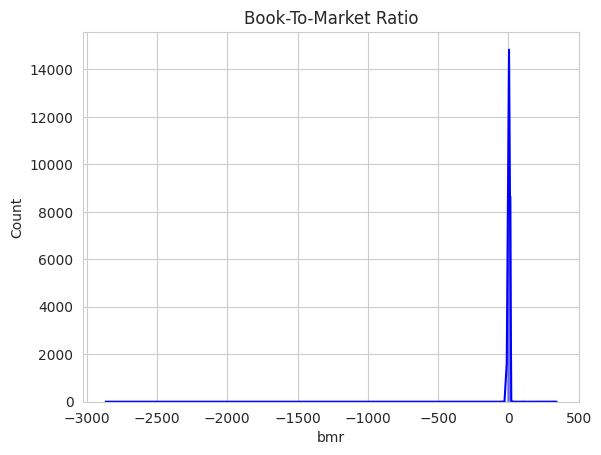

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create the histogram plot
sns.histplot(datam['bmr'], bins=100, kde=True, color='blue')

# Set the title
plt.title('Book-To-Market Ratio')

# Display the plot
plt.show()

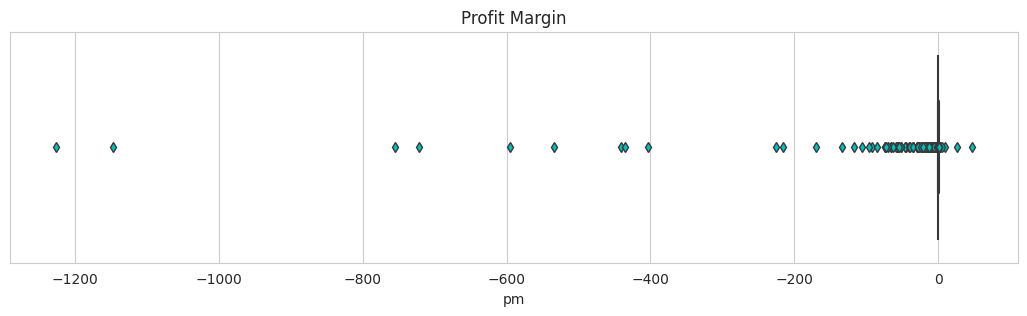

In [33]:
# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(13, 3))

# Create the box plot
sn.boxplot(x='pm', data=datam, color='m',
            whiskerprops={'linestyle': ':', 'linewidth': 3},
            medianprops={'linewidth': 0.1},
            flierprops={'markerfacecolor': 'c', 'marker': 'd', 'markersize': 5})

# Set the x-axis label
plt.xlabel('pm')

# Set the title
plt.title('Profit Margin')

# Display the plot
plt.show()

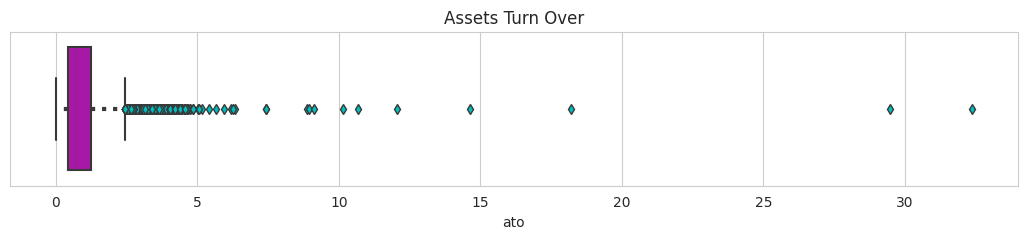

In [34]:
# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(13, 2))

# Create the box plot
sn.boxplot(x='ato', data=datam, color='m',
            whiskerprops={'linestyle': ':', 'linewidth': 3},
            medianprops={'linewidth': 0.1},
            flierprops={'markerfacecolor': 'c', 'marker': 'd', 'markersize': 5})

# Set the x-axis label
plt.xlabel('ato')

# Set the title
plt.title('Assets Turn Over')

# Display the plot
plt.show()

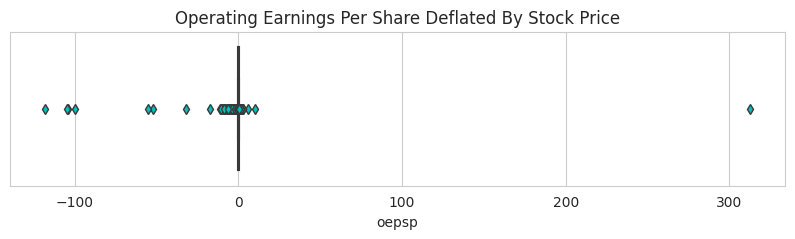

In [35]:
# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 2))

# Create the box plot
sn.boxplot(x='oepsp', data=datam, color='m',
            whiskerprops={'linestyle': ':', 'linewidth': 3},
            medianprops={'linewidth': 0.1},
            flierprops={'markerfacecolor': 'c', 'marker': 'd', 'markersize': 5})

# Set the x-axis label
plt.xlabel('oepsp')

# Set the title
plt.title('Operating Earnings Per Share Deflated By Stock Price')

# Display the plot
plt.show()

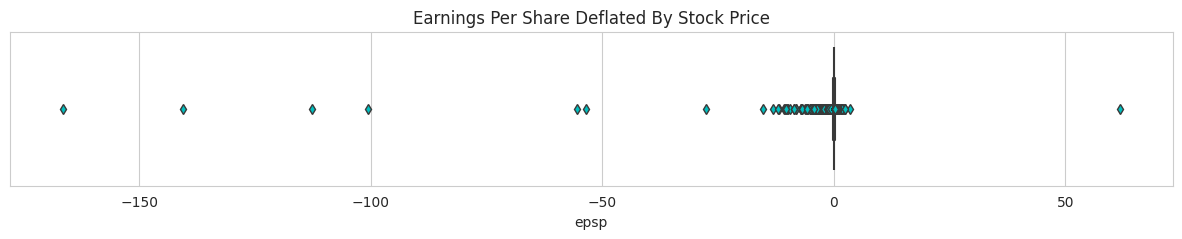

In [36]:
# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 2))

# Create the box plot
sn.boxplot(x='epsp', data=datam, color='m',
            whiskerprops={'linestyle': ':', 'linewidth': 3},
            medianprops={'linewidth': 0.1},
            flierprops={'markerfacecolor': 'c', 'marker': 'd', 'markersize': 5})

# Set the x-axis label
plt.xlabel('epsp')

# Set the title
plt.title('Earnings Per Share Deflated By Stock Price')

# Display the plot
plt.show()

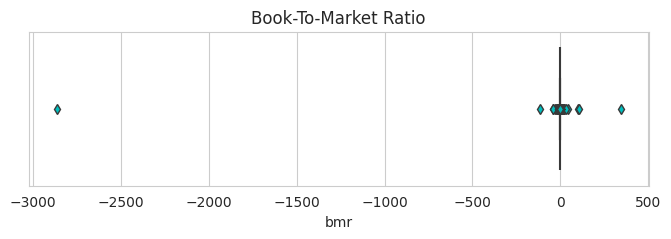

In [37]:
# Set the style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 2))

# Create the box plot
sn.boxplot(x='bmr', data=datam, color='m',
            whiskerprops={'linestyle': ':', 'linewidth': 3},
            medianprops={'linewidth': 0.1},
            flierprops={'markerfacecolor': 'c', 'marker': 'd', 'markersize': 5})

# Set the x-axis label
plt.xlabel('bmr')

# Set the title
plt.title('Book-To-Market Ratio')

# Display the plot
plt.show()

Through the histograms and the different box plots we can clearly observe that all ratios have outliers. This is a sign that we could proceed with winsorisation of each of the variables in order to reduce the impact that the outliers could have on the models

Winsorization is a technique used to reduce the impact of outliers on a dataset. It is done by replacing the most extreme values in the dataset with the nearest non-outlier values.


We will try to maintain the majority of the original data. However we must determine the level oj winsorisation for each of the ratios:

* Profit Margin (pm):

	The distribution of pm has outliers at the high end, but the distribution is otherwise relatively normal. Level 1 winsorization is sufficient to reduce the impact of the outliers without making the distribution too different from its original form.

* Operating Earnings per Share Deflated by Stock Price (oepsp):

	The distribution of oepsp has outliers at both the high and low ends, and level 2 winsorization is more effective at reducing the impact of outliers than level 1 winsorization.

* Earnings per Share Deflated by Stock Price (epsp):

    The distribution of epsp has outliers at both the high and low ends, and level 2 winsorization is more effective at reducing the impact of outliers than level 1 winsorization.


* Book-To-Market (bmr):

    Very similar pattern and behaviour of outliers to the oepsp and epsp so level 2 winsorizations would be more effective at reducing the impact of outliers.

* Asset Turn Over (ato):

    Quite similar to bmr, oepsp and epsp since it has outliers at both ends so level 2 winsorisation is applied


In [38]:
# Calculate the interquartile range (IQR)
iqr = datam['epsp'].quantile(0.75) - datam['epsp'].quantile(0.25)

# Calculate the lower and upper bounds for level 2 winsorization
lower_bound = datam['epsp'].quantile(0.01) - 1.5 * iqr
upper_bound = datam['epsp'].quantile(0.99) + 1.5 * iqr

# Apply level 2 winsorization using the calculated bounds
datam['winsorized_epsp'] = datam['epsp'].clip(lower=lower_bound, upper=upper_bound)


In [39]:
# Calculate the interquartile range (IQR)
iqr = datam['oepsp'].quantile(0.75) - datam['oepsp'].quantile(0.25)

# Calculate the lower and upper bounds for level 2 winsorization
lower_bound = datam['oepsp'].quantile(0.01) - 1.5 * iqr
upper_bound = datam['oepsp'].quantile(0.99) + 1.5 * iqr

# Apply level 2 winsorization using the calculated bounds
datam['winsorized_oepsp'] = datam['oepsp'].clip(lower=lower_bound, upper=upper_bound)

In [40]:
# Calculate the first quartile (Q1) and third quartile (Q3)
q1 = datam['pm'].quantile(0.25)
q3 = datam['pm'].quantile(0.75)

# Apply level 1 winsorization
datam['winsorized_pm'] = datam['pm'].clip(lower=q1, upper=q3)

In [41]:
# Calculate the interquartile range (IQR)
iqr = datam['bmr'].quantile(0.75) - datam['bmr'].quantile(0.25)

# Calculate the lower and upper bounds for level 2 winsorization
lower_bound = datam['bmr'].quantile(0.01) - 1.5 * iqr
upper_bound = datam['bmr'].quantile(0.99) + 1.5 * iqr

# Apply level 2 winsorization using the calculated bounds
datam['winsorized_bmr'] = datam['bmr'].clip(lower=lower_bound, upper=upper_bound)

In [42]:
# Calculate the interquartile range (IQR)
iqr = datam['ato'].quantile(0.75) - datam['ato'].quantile(0.25)

# Calculate the lower and upper bounds for level 2 winsorization
lower_bound = datam['ato'].quantile(0.01) - 1.5 * iqr
upper_bound = datam['ato'].quantile(0.99) + 1.5 * iqr

# Apply level 2 winsorization using the calculated bounds
datam['winsorized_ato'] = datam['ato'].clip(lower=lower_bound, upper=upper_bound)

In [43]:
print("\t Mean")

print("Winsorized Profit Margin:", datam['winsorized_pm'].mean())
print("Winsorized Asset Turn Over: ",datam['winsorized_ato'].mean())
print("Winsorized Operating earnings per share deflated by stock price ",datam['winsorized_oepsp'].mean())
print("Winsorized Earnings per share deflated by stock price",datam['winsorized_epsp'].mean())
print("Winsorized Book-To-Market: ",datam['winsorized_bmr'].mean())

	 Mean
Winsorized Profit Margin: 0.037075815294496106
Winsorized Asset Turn Over:  0.9169657353875001
Winsorized Operating earnings per share deflated by stock price  -0.0006833509491421845
Winsorized Earnings per share deflated by stock price -0.05029767484243141
Winsorized Book-To-Market:  0.4687806476726662


In [44]:
print('\t Median')

print("Winsorized Profit Margin", datam['winsorized_pm'].median())
print("Winsorized Asset Turn Over",datam['winsorized_ato'].median())
print("Winsorized Operating earnings per share deflated by stock price ",datam['winsorized_oepsp'].median())
print("Winsorized Earnings per share deflated by stock price",datam['winsorized_epsp'].median())
print("Winsorized Book-To-Market",datam['winsorized_bmr'].median())

	 Median
Winsorized Profit Margin 0.04005186122436228
Winsorized Asset Turn Over 0.7292887739280822
Winsorized Operating earnings per share deflated by stock price  0.054394280302460775
Winsorized Earnings per share deflated by stock price 0.030590367597219593
Winsorized Book-To-Market 0.3597357124226359


# 1.2.3 Multicollinearity

Before constructing a regression model, it is prudent to analyze the predictor variables for multicollinearity. Multicollinearity occurs when two or more independent variables are highly correlated. This can reduce the precision of regression coefficient estimates and make their interpretation difficult. In particular, with collinear variables it becomes hard to determine the distinct impact of each one on the dependent variable. Ultimately, multicollinearity can render the model unstable and unreliable.

Therefore, when building a regression model, it is standard procedure to examine the degree of multicollinearity among the predictors. A common metric used for this purpose is Variance Inflation Factor (VIF). Applying VIF will quantify the severity of correlation between the independent variables under consideration. This constitutes a logical next step in developing a statistically sound regression model.

In [45]:
datam_temp = datam.dropna()
X = datam_temp[['pm', 'ato', 'epsp', 'oepsp', 'bmr']]

Y = datam_temp[['f1ry']]

In [46]:
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

  Variable       VIF
0       pm  1.000986
1      ato  1.125626
2     epsp  8.696585
3    oepsp  8.649983
4      bmr  1.107399


 A VIF of 1 indicates no multicollinearity, while a VIF of 10 or higher indicates a severe problem with multicollinearity.

As you can see, the variables epsp and oepsp have very high VIFs, indicating that they are highly collinear. This means that these two variables are very similar to each other, and that they are providing redundant information to the regression model. This can make it difficult to interpret the results of the model, and can also make the model less accurate.

The variables pm, ato, and bmr have lower VIFs, but they are still above the recommended threshold of 1. This suggests that there is some degree of multicollinearity among these variables, but it is not as severe as the multicollinearity between epsp and oepsp.

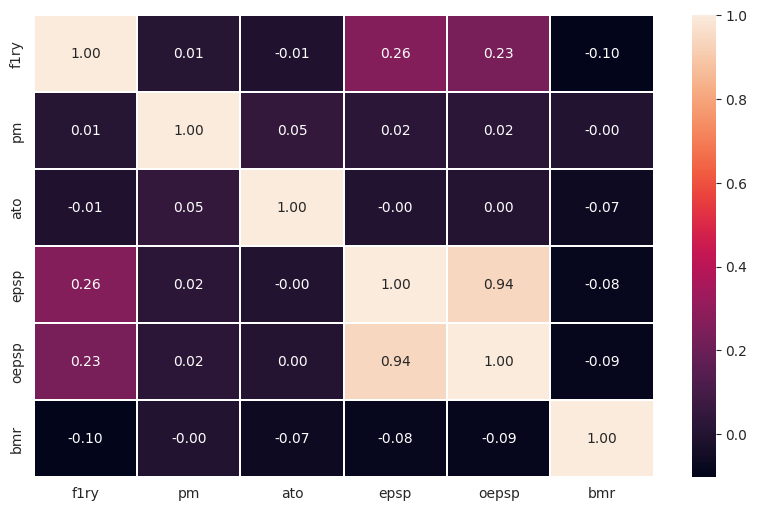

In [47]:
# Correlation matrix
data_corr = datam_temp[['f1ry','pm', 'ato', 'epsp', 'oepsp', 'bmr']]
corr_matrix = data_corr.corr()

# show heatmap
plt.figure(figsize=(10, 6))
sn.heatmap(corr_matrix, annot=True, linewidths=0.3, fmt='0.2f')
plt.show()

f1ry is positively correlated with pm, ato, epsp, and oepsp. This means that when these variables increase, f1ry also tends to increase. The correlation coefficients are relatively strong, suggesting that these variables have a significant impact on f1ry.


f1ry is negatively correlated with bmr. This means that when bmr increases, f1ry tends to decrease. The correlation coefficient is relatively weak, suggesting that bmr has a smaller impact on f1ry than the other variables.


There is a high degree of correlation between epsp and oepsp (0.99). This means that these two variables are very similar to each other, and that they are providing redundant information.

Based on the information of the correlation matrix:
* We should  either use epsp or oepsp in the model, but not both.
* Also the variable of bmr is not as strongly correlated with f1ry as the other variables.


In [49]:
import statsmodels.api as sm
import numpy as np

# Add constant column to X
X = sm.add_constant(X)

# Fit the model with all variables
model_regression = sm.OLS(Y, X).fit()

# Fit the model only with 'oepsp'
X_oepsp = X["oepsp"]
X_oepsp = sm.add_constant(X_oepsp)
model_oepsp = sm.OLS(Y, X_oepsp).fit()

# Compare the adjusted R-squared values of the models
r_squared_original = model_regression.rsquared
r_squared_epsp = model_oepsp.rsquared

# Print the adjusted R-squared values
print("Adjusted R-squared (Benchmark Model):", r_squared_original)
print("Adjusted R-squared (Model with 'oepsp'):", r_squared_epsp)

Adjusted R-squared (Benchmark Model): 0.07834335233143008
Adjusted R-squared (Model with 'oepsp'): 0.05454038131563965


A standard approach for evaluating predictor importance involves constructing multiple regression models and comparing their coefficient of determination (R-squared) values. First, a benchmark model is estimated using all candidate predictor variables.

 This establishes an overall benchmark for model fit. Additional "alternative" models are then estimated, each incorporating a single predictor variable of interest.

By comparing R-squared values between the benchmark and alternative specifications, one can assess the marginal contribution of each predictor. If an alternative model achieves an R-squared value similar to the original, it suggests the corresponding variable may supply redundant information in context of the other predictors. Specifically, if the difference in R-squared falls below a pre-determined threshold, the similarity indicates that removing the variable may not substantially impact model fit.

Adjusted R-squared (Benchmark Model): 0.07834335233143008

This adjusted R-squared value indicates that the benchmark model explains about 7.83% of the variation in the dependent variable. This means that the benchmark model is not a very good fit for the data, as there is still a lot of unexplained variation in the dependent variable.

Adjusted R-squared (Model with 'oepsp'): 0.05454038131563965

This adjusted R-squared value indicates that the model with 'oepsp' explains about 5.45% of the variation in the dependent variable. This means that the model with 'oepsp' is an even worse fit for the data than the benchmark model.

The low adjusted R-squared values for both models suggest that there are other factors that are affecting the dependent variable that are not included in the models.


In [50]:
X = datam_temp[['pm', 'ato', 'oepsp', 'bmr']]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

  Variable       VIF
0       pm  1.000794
1      ato  1.098151
2    oepsp  1.008234
3      bmr  1.106315


The VIF values for all four independent variables (pm, ato, epsp, and bmr) are relatively low, ranging from 1.000959 to 1.107399. This suggests that there is no significant multicollinearity among these variables, and they can be used in the regression model without major concerns.

# 1.2.4 Multiple Regression Model

* Run a first multiple regression model to examine whether the financial ratios and firm size explain/predict future annual stock returns (one quarter later). For the ratios, use the winsorized version (if the ratio has extreme values)

In [51]:
X = datam_temp[['winsorized_pm', 'winsorized_ato', 'winsorized_oepsp', 'winsorized_bmr', 'sizegroup_medium', 'sizegroup_large']]
X = sm.add_constant(X)

Y = datam_temp[['f1ry']]

In [52]:
mkmodel = sm.OLS(Y, X, missing = 'drop').fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1ry   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     137.8
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          1.68e-165
Time:                        02:42:10   Log-Likelihood:                -5242.8
No. Observations:                6934   AIC:                         1.050e+04
Df Residuals:                    6927   BIC:                         1.055e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0420      0.018  

Interpret your model

Interpret the results of each coefficient (beta and their statistical significance). Remember that the coefficients of categorical dummies have a special interpretation.

The R-squared value of 0.107 indicates that the model explains about 10.7% of the variation in the dependent variable (f1ry). This is a relatively low R-squared value, suggesting that there are other factors that are affecting f1ry that are not included in the model.

The F-statistic of 137.8 is highly significant (p-value < 1.68e-165), indicating that the model as a whole is statistically significant. This means that there is a statistically significant relationship between the independent variables and the dependent variable.

* const: The constant term represents the expected value of f1ry when all of the independent variables are zero. In this case, the constant term is 0.0420, which means that we would expect f1ry to be 0.0420 if all of the independent variables were zero.

* winsorized_pm: The coefficient for winsorized_pm is 0.0714, but it is not statistically significant (p-value = 0.642). This means that there is not a statistically significant relationship between winsorized_pm and f1ry.

* winsorized_ato: The coefficient for winsorized_ato is -0.0054, but it is not statistically significant (p-value = 0.545). This means that there is not a statistically significant relationship between winsorized_ato and f1ry.

* winsorized_oepsp: The coefficient for winsorized_oepsp is 0.5606, and it is highly statistically significant (p-value < 0.000). This means that for every one-unit increase in winsorized_oepsp, we expect f1ry to increase by 0.5606.

* winsorized_bmr: The coefficient for winsorized_bmr is -0.1146, and it is highly statistically significant (p-value < 0.000). This means that for every one-unit increase in winsorized_bmr, we expect f1ry to decrease by 0.1146.

* sizegroup_medium: The coefficient for sizegroup_medium is 0.0542, and it is statistically significant (p-value = 0.001). This means that companies in the medium size group have an expected f1ry that is 0.0542 higher than companies in the reference group (small).

* sizegroup_large: The coefficient for sizegroup_large is 0.0720, and it is statistically significant (p-value < 0.000). This means that companies in the large size group have an expected f1ry that is 0.0720 higher than companies in the reference group (small).

In this case, the coefficients for sizegroup_medium and sizegroup_large are both positive and statistically significant. This means that companies in the medium and large size groups have an expected f1ry that is higher than companies in the small size group.


* Add interaction terms between firm size and earnings per share deflated by price (in case you eliminated one due to multicolienarity).

In [53]:
datam_temp['winsorized_oepsp_size_medium'] = datam_temp['winsorized_epsp'] * datam_temp['sizegroup_medium']
datam_temp['winsorized_oepsp_size_large'] = datam_temp['winsorized_epsp'] * datam_temp['sizegroup_large']

<ipython-input-53-d3d45104586e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datam_temp['winsorized_oepsp_size_medium'] = datam_temp['winsorized_epsp'] * datam_temp['sizegroup_medium']
<ipython-input-53-d3d45104586e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datam_temp['winsorized_oepsp_size_large'] = datam_temp['winsorized_epsp'] * datam_temp['sizegroup_large']


In [54]:
X = datam_temp[['winsorized_pm', 'winsorized_ato', 'winsorized_oepsp', 'winsorized_bmr', 'sizegroup_medium', 'sizegroup_large', 'winsorized_oepsp_size_medium', 'winsorized_oepsp_size_large']]
X = sm.add_constant(X)

In [55]:
mkmodel = sm.OLS(Y, X, missing = 'drop').fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                   f1ry   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     108.6
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          1.57e-171
Time:                        02:42:29   Log-Likelihood:                -5223.9
No. Observations:                6934   AIC:                         1.047e+04
Df Residuals:                    6925   BIC:                         1.053e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Re-run the regression and INTERPRET the interaction between these two variables. Also, state the regression equation for each size group.


The coefficient for the interaction term between winsorized_oepsp and sizegroup_medium is -0.2433, and it is statistically significant (since it has a p-value of 0.000). This means that the effect of winsorized_oepsp on f1ry is different for companies in the medium size group compared to the reference group (small). Specifically, the effect of winsorized_oepsp is negative for companies in the medium size group, meaning that as winsorized_oepsp increases, f1ry decreases for these companies.


The coefficient for the interaction term between winsorized_oepsp and sizegroup_large is -0.6048, and it is also statistically significant (p-value < 0.000). This means that the effect of winsorized_oepsp on f1ry is also different for companies in the large size group compared to the reference group (small). Specifically, the effect of winsorized_oepsp is even more negative for companies in the large size group compared to companies in the medium size group.

These are the regression equations for each size group:

_Small size group_:

f1ry = 0.0339 + 0.3251 * winsorized_pm - 0.0009 * winsorized_ato + 0.6013 * winsorized_oepsp - 0.1106 * winsorized_bmr + 0.0461 * sizegroup_medium + 0.0770 * sizegroup_large

_Medium size group_:

f1ry = 0.0339 + 0.3251 * winsorized_pm - 0.0009 * winsorized_ato + 0.6013 * winsorized_oepsp - 0.1106 * winsorized_bmr - 0.2433 * (winsorized_oepsp * sizegroup_medium) + 0.0461 * sizegroup_medium + 0.0770 * sizegroup_large

_Large size group_:

f1ry = 0.0339 + 0.3251 * winsorized_pm - 0.0009 * winsorized_ato + 0.6013 * winsorized_oepsp - 0.1106 * winsorized_bmr - 0.6048 * (winsorized_oepsp * sizegroup_large) + 0.0461 * sizegroup_medium + 0.0770 * sizegroup_large



* Interpret the R-squared of the model

The R-squared value of 0.112 indicates that this OLS regression model explains about 11.2% of the variation in the dependent variable (f1ry). This means that the model only accounts for a relatively small portion of the factors that influence f1ry.


* Run a multiple regression but now using only the last complete year of data (yearf=2022)

In [56]:
datatemp_2022 = dataser.query('yearf == 2022 and fiscalmonth == 12')
datatemp_2022.dropna()

,firm,q,fiscalmonth,revenue,cogs,sgae,otherincome,extraordinaryitems,finexp,incometax,...,industria,ebit,opm,netincome,pm,ato,acidratio,finlev,mvalue,bookvalue
5882,ACM,2022q3,12.0,1.314818e+07,1.230021e+07,2.548100e+05,14152.000,-50380.000,110274.000,136051.000,...,"Servicios profesionales, científicos y técnicos",5.931640e+05,0.045114,3.972190e+05,0.030211,1.180340,1.077466,0.247052,9.547850e+06,2.605379e+06
32193,APDN,2022q3,12.0,1.816868e+04,1.311504e+04,1.902340e+04,5692.504,2.168,-7.200,0.000,...,Servicios de apoyo a los negocios y manejo de ...,-1.396976e+04,-0.768893,-1.396473e+04,-0.768616,0.816015,4.765033,0.000000,1.455725e+04,1.290894e+04
37228,ARKR,2022q3,12.0,1.836740e+05,0.000000e+00,1.738100e+05,2841.000,-893.000,1083.000,1448.000,...,Servicios de alojamiento temporal y de prepara...,9.864000e+03,0.053704,8.226000e+03,0.044786,0.876583,1.120689,0.546608,6.693157e+04,6.011800e+04
37513,ARMK,2022q3,12.0,1.632662e+07,1.476757e+07,9.306890e+05,0.000,307.000,372727.000,61461.000,...,Servicios de alojamiento temporal y de prepara...,6.283650e+05,0.038487,1.938700e+05,0.011874,1.082493,1.001858,0.507311,8.040761e+06,3.029640e+06
42547,ATGE,2022q2,12.0,1.387122e+06,6.597760e+05,6.468820e+05,0.000,347532.000,125528.000,-15237.000,...,Servicios educativos,8.046400e+04,0.058008,-3.773590e+05,-0.272045,0.457921,1.331744,0.335389,1.623813e+06,1.505067e+06
57745,BDL,2022q3,12.0,1.581320e+05,0.000000e+00,1.512030e+05,3640.000,-2737.000,757.000,763.000,...,Servicios de alojamiento temporal y de prepara...,6.929000e+03,0.043818,8.146000e+03,0.051514,1.072140,2.294959,0.348297,4.743267e+04,7.334000e+04
71722,BR,2022q2,12.0,5.709100e+06,4.116900e+06,8.323000e+05,-3000.000,0.000,84700.000,133100.000,...,Servicios de apoyo a los negocios y manejo de ...,7.599000e+05,0.133103,5.421000e+05,0.094954,0.698891,1.011421,0.464328,1.671068e+07,1.919000e+06
80177,CACI,2022q2,12.0,6.202917e+06,4.051188e+06,1.655400e+06,0.000,0.000,41757.000,87778.000,...,"Servicios profesionales, científicos y técnicos",4.963290e+05,0.080015,3.667940e+05,0.059133,0.935664,1.177423,0.304319,6.597217e+06,3.053543e+06
85783,CBRL,2022q3,12.0,3.267786e+06,1.049884e+06,2.064899e+06,0.000,0.000,9620.000,11503.000,...,Servicios de alojamiento temporal y de prepara...,1.530030e+05,0.046822,1.318800e+05,0.040358,1.423927,0.631616,0.499108,2.051653e+06,5.114790e+05
120115,CSPI,2022q3,12.0,5.436100e+04,3.553400e+04,1.886700e+04,1689.000,0.000,-290.000,50.000,...,"Servicios profesionales, científicos y técnicos",-4.000000e+01,-0.000736,2.000000e+02,0.003679,0.724215,1.969949,0.014282,3.275632e+04,3.896300e+04


In [57]:
merged_data = datatemp_2022.merge(datam_temp, on="firm", how="inner")

In [58]:
data_final_year = merged_data.query('yearf_x == 2022')

In [59]:
X = data_final_year[['winsorized_pm', 'winsorized_ato', 'winsorized_oepsp', 'winsorized_bmr', 'sizegroup_medium', 'sizegroup_large', 'winsorized_oepsp_size_medium', 'winsorized_oepsp_size_large']]
X = sm.add_constant(X)

Y = data_final_year[['f1ry_y']]
mkmodel = sm.OLS(Y, X, missing = 'drop').fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                 f1ry_y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     80.29
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          1.95e-125
Time:                        02:42:40   Log-Likelihood:                -3840.1
No. Observations:                5060   AIC:                             7698.
Df Residuals:                    5051   BIC:                             7757.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

* What differences do you see compared with the previous model? Explain


Overall, the two models have very similar performance, with both explaining about 11% of the variation in the dependent variable (f1ry). The F-statistics for both models are also highly significant, indicating that there is a statistically significant relationship between the independent variables and the dependent variable.

However, there are a few key differences between the two models. First, the model that is delimited to the last complete year as the dependent variable has a slightly higher R-squared value (0.113) compared to the model with f1ry as the dependent variable (0.112). This suggests that the model with f1ry_y explains a slightly greater proportion of the variation in the dependent variable.

Second, the coefficients for the sizegroup_medium and sizegroup_large dummy variables are no longer statistically significant in the model with f1ry_y as the dependent variable. This suggests that the effect of size group on f1ry is not as strong when using f1ry_y as the dependent variable.

Finally, the coefficients for the interaction term between winsorized_oepsp and sizegroup are larger in the model with f1ry_y as the dependent variable. This suggests that the interaction between winsorized_oepsp and sizegroup is stronger when using f1ry_y as the dependent variable.

# 1.2.5 Regression Diagnosis

Using matrix algebra calculate the beta coefficients of the same regression model

In [60]:
beta = np.linalg.inv(X.T @ X) @ X.T @ Y
print(beta)

     f1ry_y
0  0.051992
1  0.343509
2  0.001949
3  0.646320
4 -0.107750
5  0.029168
6  0.069363
7 -0.287652
8 -0.982856


This calculates the coefficients of an OLS regression model using NumPy's matrix operations and linear algebra functions.

It does this by calculating the matrix product of the inverse of the matrix product of the transpose of X and X and the matrix product of the transpose of X and Y.

In [61]:
# Obtain the beta coefficients
beta_python = mkmodel.params

print("Beta Coefficients:")
print(beta_python)

Beta Coefficients:
const                           0.051992
winsorized_pm                   0.343509
winsorized_ato                  0.001949
winsorized_oepsp                0.646320
winsorized_bmr                 -0.107750
sizegroup_medium                0.029168
sizegroup_large                 0.069363
winsorized_oepsp_size_medium   -0.287652
winsorized_oepsp_size_large    -0.982856
dtype: float64


Using matrix algebra calculate the Hat Matrix

In [62]:
H = np.dot(np.dot(X, np.linalg.inv(X.T @ X)), X.T)
print(H)

[[ 6.88830759e-04  1.48994405e-03  7.87588821e-04 ...  4.23809663e-04
   4.22795550e-04  3.88850240e-04]
 [ 1.48994405e-03  6.79701451e-03  2.25204722e-03 ...  1.28007365e-05
  -1.85281429e-05 -2.44741705e-04]
 [ 7.87588821e-04  2.25204722e-03  1.05265660e-03 ...  5.10158164e-04
   4.99749615e-04  4.28919460e-04]
 ...
 [ 4.23809663e-04  1.28007365e-05  5.10158164e-04 ...  1.79800733e-03
   1.78407191e-03  1.75931793e-03]
 [ 4.22795550e-04 -1.85281429e-05  4.99749615e-04 ...  1.78407191e-03
   1.77183187e-03  1.75027505e-03]
 [ 3.88850240e-04 -2.44741705e-04  4.28919460e-04 ...  1.75931793e-03
   1.75027505e-03  1.74023996e-03]]


With the hat matrix identify possible leverage observations. EXPLAIN why these observations can be leverage points.

Leverage observations are data points that have an unusually large influence on the outcome of a regression analysis. They can be identified using the hat matrix (H), which is a symmetric matrix that projects the dependent variable onto the subspace spanned by the independent variables.

In general, a leverage point is considered to be an observation with a leverage value greater than 2p/n, where p is the number of independent variables and n is the number of observations. This cutoff value is based on the idea that a single observation should not have too much influence on the regression model.

Leverage points can be influential for several reasons:

They may be outliers. Leverage points are often outliers in the data, meaning that they are far from the majority of the observations. This can make them more likely to have a large impact on the regression model.

They may represent unique characteristics. Leverage points may represent unique characteristics that are not well-represented by the rest of the data. This can make them difficult to predict accurately using the regression model.

They can be sensitive to small changes in the data. Leverage points can be sensitive to small changes in the data, meaning that removing or modifying them can have a large impact on the regression model.

In [85]:
# Calculate the diagonal elements of the Hat Matrix (Hii)
hat_values = np.diag(H)

# Calculate the average Hat value
average_hat_value = np.mean(hat_values)

# Set a threshold for identifying leverage points
threshold = 2 * (X.shape[1] + 1) / X.shape[0]  # A common threshold is 2 * (p + 1) / n

# Identify leverage observations
leverage_observations = np.where(hat_values > threshold)[0]

# Display the leverage observations
print("Leverage Observations:")
print(leverage_observations)

Leverage Observations:
[   1    6    7   15   83   99  100  101  113  114  172  211  236  301
  304  315  374  375  376  377  378  379  380  383  473  474  475  476
  499  501  505  506  592  659  743  744  747  758  759  760  795  853
  854  855  856  857  858  859  860  861  862  863  864  865  866  867
  887  888  891  930 1075 1112 1117 1118 1119 1120 1121 1130 1135 1142
 1345 1346 1359 1392 1410 1485 1532 1546 1547 1548 1737 1743 1869 1871
 1873 1965 2060 2085 2086 2088 2089 2209 2210 2211 2212 2215 2216 2231
 2233 2234 2306 2410 2411 2412 2417 2536 2612 2613 2615 2639 2640 2646
 2668 2669 2676 2677 2695 2946 2948 2957 2959 2982 2983 2984 2992 2993
 3003 3004 3005 3006 3010 3019 3034 3035 3036 3164 3165 3175 3237 3345
 3346 3394 3397 3398 3405 3414 3415 3416 3440 3441 3442 3443 3444 3445
 3446 3447 3501 3543 3544 3597 3681 3691 3697 3750 3762 3763 3861 3862
 3878 3879 3880 4012 4013 4015 4043 4078 4127 4128 4129 4146 4217 4218
 4219 4221 4227 4234 4243 4339 4340 4341 4342 4349 435

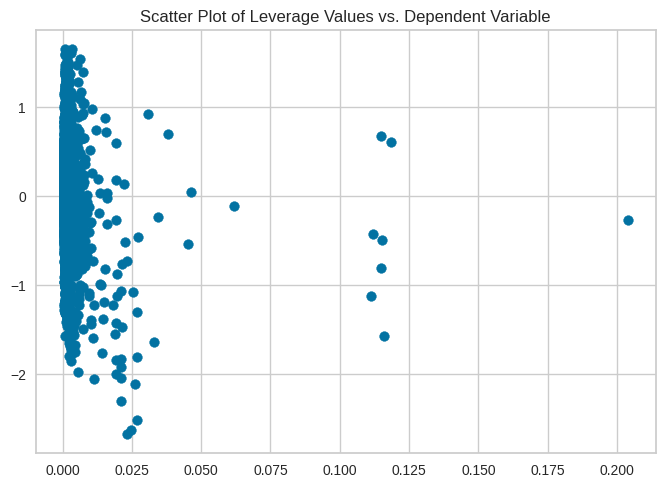

In [91]:
import matplotlib.pyplot as plt
import numpy as np

df_tmp = data_final_year
df_tmp['l'] = np.diagonal(H)

# Plot the leverage values from statsmodels framework
influence_values = mkmodel.get_influence()
l = influence_values.hat_matrix_diag
plt.title("Scatter Plot of Leverage Values vs. Dependent Variable")
plt.scatter(l, Y)


# Show the plot
plt.show()

Identify possible outliers using studentized residuals. EXPLAIN your criteria to identify these outliers, and how studentized residuals work.

Studentized residuals are a type of residual that is designed to be less likely to be found in a data set that is more skewed or has outliers. They are calculated by dividing each residual by an estimate of its standard deviation. This adjustment makes studentized residuals more comparable across different data sets and less likely to be affected by outliers.

To calculate studentized residuals, the following formula is used:

Studentized residual = residual / sqrt(MSE * h_ii)

In order to identify possible outliers using studentized residuals
we could utilize the absolute studentized residuals greater than 3 rule. Hence,observations with absolute studentized residuals greater than 3 would be considered outliers.

We could also use studentized residuals to perform a t-test on each residual. Observations with studentized residuals that are significantly different from zero (p-value < 0.05) can be considered to be outliers.


The scatter plot of leverage values vs. dependent variable shows the relationship between the leverage of each observation and its corresponding value on the dependent variable. Observations with high leverage values are those that have a large influence on the regression model.

Outliers are often high-leverage observations. This is because outliers are typically far from the majority of the data points, which gives them a large influence on the regression model.

In [66]:
# Create an OLSInfluence object
influence = mkmodel.get_influence()

# Calculate studentized residuals
studentized_residuals = influence.resid_studentized

# Define a threshold for identifying outliers
threshold = 3

# Identify outliers
studentized_outl = np.abs(studentized_residuals) > threshold

# Print the indices of the outliers
print("Index:")
print(np.where(studentized_outl)[0])

Index:
[  29   83   99  100  115  175  176  259  260  317  549  661  662  673
  758  776 1080 1128 1346 1359 1392 1418 1547 1561 1704 1714 1869 2050
 2193 2207 2210 2211 2212 2228 2306 2314 2412 2418 2740 2741 2759 2981
 2992 3003 3004 3022 3163 3237 3324 3347 3348 3414 3439 3508 3598 3636
 3729 3861 3862 3913 4051 4145 4146 4253 4301 4354 4378 4399 4406 4532
 4533 4708 4712 4903 4955 4987 5011 5019]


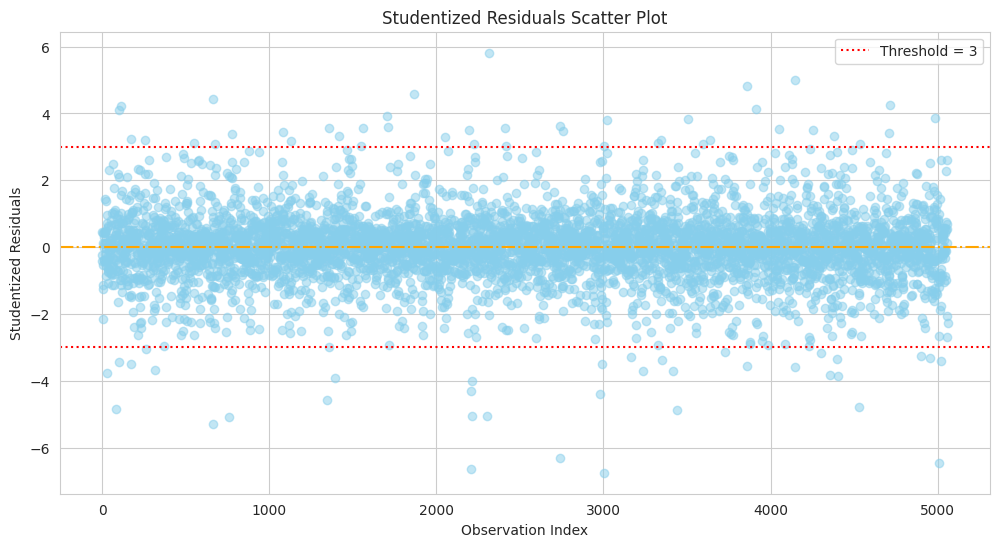

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
plt.figure(figsize=(12, 6))

# Scatter plot with modified colors and linestyles
plt.scatter(np.arange(len(studentized_residuals)), studentized_residuals, alpha=0.5, color='skyblue')
plt.axhline(y=0, color='orange', linestyle='-.')
plt.axhline(y=threshold, color='red', linestyle=':', label=f"Threshold = {threshold}")
plt.axhline(y=-threshold, color='red', linestyle=':')

# Set the title and axis labels
plt.title("Studentized Residuals Scatter Plot")
plt.xlabel("Observation Index")
plt.ylabel("Studentized Residuals")
plt.legend()

# Show the plot
plt.show()

In [68]:
# Get the influence object for the model
influence = mkmodel.get_influence()

# Calculate and retrieve the summary frame, which contains various diagnostic statistics
summary_frame = influence.summary_frame()

# Extract the desired diagnostic statistics
student_resid = summary_frame["student_resid"]

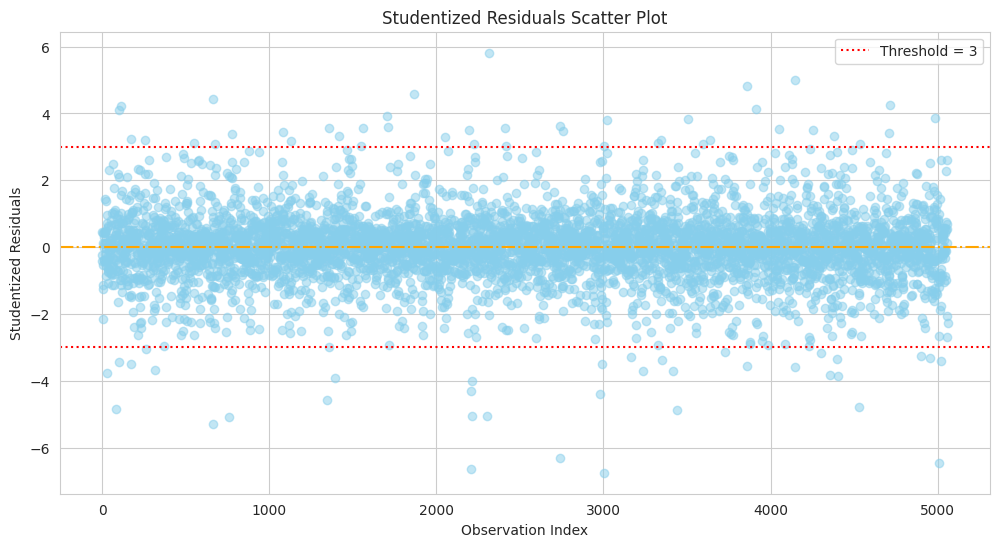

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
plt.figure(figsize=(12, 6))

# Scatter plot with modified colors and linestyles
plt.scatter(np.arange(len(studentized_residuals)), studentized_residuals, alpha=0.5, color='skyblue')
plt.axhline(y=0, color='orange', linestyle='-.')
plt.axhline(y=threshold, color='red', linestyle=':', label=f"Threshold = {threshold}")
plt.axhline(y=-threshold, color='red', linestyle=':')

# Set the title and axis labels
plt.title("Studentized Residuals Scatter Plot")
plt.xlabel("Observation Index")
plt.ylabel("Studentized Residuals")
plt.legend()

# Show the plot
plt.show()

In [93]:
# Create an OLSInfluence object
influence = mkmodel.get_influence()

# Calculate studentized residuals
studentized_residuals = influence.resid_studentized

# Define a threshold for identifying outliers
threshold = 3

# Identify outliers
studentized_outl = np.abs(studentized_residuals) > threshold

# Count the number of outliers
num_outliers = np.count_nonzero(studentized_outl)

# Print the number of outliers
print("Number of outliers:", num_outliers)


Number of outliers: 54


The observations that are beyond the threhold of 3 could be considered outliers. Outliers are data points that are significantly different from the rest of the data. They can be caused by errors in data collection or entry, or they may represent unique characteristics that are not well-represented by the rest of the data.

The observations may be high-leverage observations. High-leverage observations are data points that have a large influence on the regression model. They can be caused by having a large value on one or more of the independent variables, or they may be located in a region of the data where the relationship between the independent and dependent variables is strong.

Identify possible outliers using Cook’s distance. EXPLAIN your criteria to identify outliers with Cook’s distance and how they work.

Cook's distance is a measure of the influence of each data point on the fitted regression line. It takes into account both the leverage of the data point and its residual. A high Cook's distance indicates that a data point has a large influence on the fitted line, and this data point may be an outlier.

A common rule of thumb is to consider any data point with a Cook's distance greater than 1 to be an outlier.

Another criteria in order to identify outliers is the following:
Cook's distance greater than 4/n: This rule of thumb is based on the idea that a single observation should not have too much influence on the regression model.

Cook's distance = (residual^2) / (p * MSE * h_ii)


In [70]:
influence = mkmodel.get_influence()
cooks_distance = influence.cooks_distance
cooks_distance_values = cooks_distance[0]
# Calculate the threshold (4/n)
n = len(Y)
threshold = 4 / n

# Identify outliers based on Cook's distance
outliers_cooks = cooks_distance_values > threshold

# Print the indices of the outliers
print("Index:")
print(np.where(outliers_cooks)[0])

Index:
[   5    6    7   29   39   64   83   99  100  101  113  115  172  175
  176  194  216  218  229  235  236  259  260  301  308  315  317  371
  376  378  380  383  458  470  474  475  487  491  505  506  533  548
  549  574  581  588  592  600  643  646  661  662  673  678  742  743
  744  747  748  758  759  776  777  795  797  799  851  881  886  887
  939  940 1076 1079 1080 1109 1112 1116 1117 1118 1119 1120 1121 1128
 1130 1135 1142 1181 1193 1194 1323 1346 1354 1358 1359 1392 1397 1411
 1418 1460 1469 1476 1485 1489 1494 1495 1532 1544 1547 1548 1561 1704
 1714 1720 1772 1777 1795 1843 1869 1873 1912 1921 1931 1942 1965 2049
 2050 2060 2181 2187 2192 2193 2207 2210 2211 2212 2214 2227 2228 2231
 2234 2306 2313 2314 2365 2412 2416 2418 2426 2428 2513 2522 2536 2598
 2600 2615 2616 2617 2636 2740 2741 2758 2759 2888 2940 2946 2948 2949
 2959 2977 2981 2982 2983 2984 2992 2993 2994 3003 3004 3015 3020 3022
 3163 3164 3165 3173 3193 3236 3237 3253 3284 3312 3313 3324 3326 3327

In [92]:
influence = mkmodel.get_influence()
cooks_distance = influence.cooks_distance
cooks_distance_values = cooks_distance[0]

# Calculate the threshold (4/n)
n = len(Y)
threshold = 4 / n

# Identify outliers based on Cook's distance
outliers_cooks = cooks_distance_values > threshold

# Count the number of outliers
num_outliers = np.count_nonzero(outliers_cooks)

# Print the number of outliers
print("Number of outliers:", num_outliers)


Number of outliers: 343


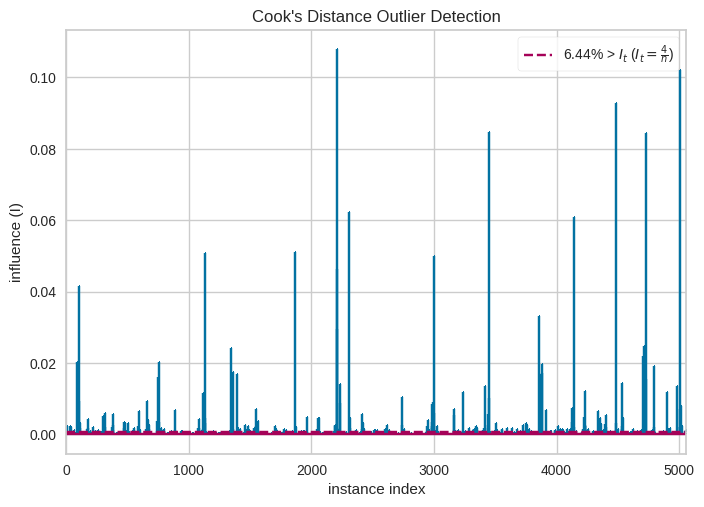

<Axes: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [71]:
from yellowbrick.regressor import CooksDistance
influence_values = mkmodel.get_influence()
l = influence_values.hat_matrix_diag

Y = Y.values.reshape(-1)

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, Y)
visualizer.show()

Using studentized residuals and Cook’s distance identify possible influential observations. EXPLAIN your criteria.

Observations with both an absolute studentized residual greater than 3 and a Cook's distance greater than 1.
Observations with Cook's distance greater than 4/n and observations with absolute studentized residual greater than 3. These observations have a disproportionately large influence on the fitted line and should be considered influential.
Observations with either an absolute studentized residual greater than 3 or a Cook's distance greater than 1, but not both.

Other things to consider would include:

Leverage: High leverage signals an observation's impact on the regression line.
Residual: Large residuals, the gap between actual and predicted values, suggest influence.
Independent Variables: More variables amplify the likelihood of influential observations.


List the influential observations and decide whether to drop them or keep some of them

With this is mind, with the studentized residuals we've got a total of 54 outliers with the rule of observations being greter than 3. And a total of 343 using the threshold = 4 / n for the Cook's distance.

In this case, with 54 outliers based on studentized residuals and 343 outliers based on Cook's distance, it's evident that the data contains a significant number of influential observations. Dropping all of these observations could lead to biased results, as it would eliminate valuable information from the dataset.

Since dropping all of these observations could lead to losing valuable information from the dataset into the model. I'd opt for utilizing the studentized residuals in order to detect and get rid of possible outliers.



In [72]:
# Combine all sets of outliers and leverage points
out_combined = studentized_outl

# Filter the original dataset to remove the outliers and leverage points
data_wo_out = data_final_year.loc[~out_combined]

data_wo_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4982 entries, 0 to 5059
Data columns (total 92 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   firm                          4982 non-null   object 
 1   q_x                           4982 non-null   object 
 2   fiscalmonth_x                 4982 non-null   float64
 3   revenue_x                     4982 non-null   float64
 4   cogs_x                        4982 non-null   float64
 5   sgae_x                        4982 non-null   float64
 6   otherincome_x                 4982 non-null   float64
 7   extraordinaryitems_x          4982 non-null   float64
 8   finexp_x                      4982 non-null   float64
 9   incometax_x                   4982 non-null   float64
 10  totalassets_x                 4982 non-null   float64
 11  currentassets_x               4982 non-null   float64
 12  inventory_x                   4982 non-null   float64
 13  tot

Re-run the multiple regression model without the influential observation. Compare the model with the previous one. Which model was better? Explain the differences

In [73]:
X = data_wo_out[['winsorized_pm', 'winsorized_ato', 'winsorized_oepsp', 'winsorized_bmr', 'sizegroup_medium', 'sizegroup_large', 'winsorized_oepsp_size_medium', 'winsorized_oepsp_size_large']]
X = sm.add_constant(X)

Y = data_wo_out[['f1ry_y']]
mkmodel = sm.OLS(Y, X, missing = 'drop').fit()
print(mkmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                 f1ry_y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     81.74
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          1.58e-127
Time:                        02:43:37   Log-Likelihood:                -3116.5
No. Observations:                4982   AIC:                             6251.
Df Residuals:                    4973   BIC:                             6310.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Model 1

The first model has an R-squared of 0.113, which means that it explains 11.3% of the variance in the dependent variable, f1ry_y. The F-statistic is 80.29, which is significant at the 0.001 level. This means that the model is a good fit for the data.

The coefficients for all of the independent variables are significant at the 0.05 level, except for winsorized_ato. This means that all of the independent variables have a statistically significant relationship with the dependent variable.

The coefficient for winsorized_pm is positive and significant, which means that an increase in winsorized_pm is associated with an increase in f1ry_y. The coefficient for winsorized_oepsp is also positive and significant, which means that an increase in winsorized_oepsp is associated with an increase in f1ry_y. The coefficients for winsorized_bmr and winsorized_oepsp_size_large are negative and significant, which means that an increase in winsorized_bmr or winsorized_oepsp_size_large is associated with a decrease in f1ry_y. The coefficients for sizegroup_medium and sizegroup_large are positive and significant, which means that an increase in sizegroup_medium or sizegroup_large is associated with an increase in f1ry_y.

Model 2

The second model has an R-squared of 0.116, which is slightly higher than the R-squared for the first model. This means that the second model explains a slightly greater percentage of the variance in the dependent variable. The F-statistic is 81.74, which is also significant at the 0.001 level. This means that the second model is also a good fit for the data.

The coefficients for all of the independent variables are significant at the 0.05 level, except for winsorized_ato. This means that all of the independent variables have a statistically significant relationship with the dependent variable in the second model as well.

The coefficients for winsorized_pm, winsorized_oepsp, winsorized_bmr, sizegroup_medium, and sizegroup_large are all in the same direction and have the same significance levels as in the first model. This means that the relationship between these variables and the dependent variable is consistent across both models.

The coefficient for winsorized_oepsp_size_medium is slightly smaller in the second model than in the first model. This means that the effect of winsorized_oepsp_size_medium on f1ry_y is slightly weaker in the second model.

The coefficient for winsorized_oepsp_size_large is also slightly smaller in the second model than in the first model. This means that the effect of winsorized_oepsp_size_large on f1ry_y is also slightly weaker in the second model.

Differences

The R-squared value for Model 2 is slightly higher (0.116) than that of Model 1 (0.113), suggesting that Model 2 explains a marginally greater proportion of the variance in f1ry_y.

The coefficients for winsorized_oepsp_size_medium and winsorized_oepsp_size_large exhibit minor changes in magnitude between the two models. In Model 2, the effects of these interactions on f1ry_y are slightly weaker compared to Model 1.

Overall

Both models are good fits for the data and explain a significant amount of the variance in the dependent variable. The coefficients for all of the independent variables are significant in both models, except for winsorized_ato. The relationship between the independent variables and the dependent variable is consistent across both models.
